# Data & Figures for Grey-Loading Paper

## HOW TO USE:

You must run the two initialization cells below, and then any section should run by itself.  

## Imports and initialization

In [705]:
day = '1'
month = 'January'
year = '1900'
from CalibrationModules import D1_DacToFreq, TweezerPowerToDepth, MOT_DacToFreq
import numpy as np
from numpy import array as arr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import style
from matplotlib import ticker
from fitters import gaussian
import mpl_toolkits.axes_grid1 as axesTool
%matplotlib inline
style.use(['default'])
import matplotlib as mpl
import math
import scipy.optimize as opt
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ExpFile import setPath
import ExpFile as exp
from VersionManagement import getVersions
import PlotlyPlotters as pp
import MatplotlibPlotters as mp
import MainAnalysis as ma
import AnalysisHelpers as ah
import Miscellaneous as misc
import MarksConstants as mc
from importlib import reload
def reloadMyModules():
    reload(exp)
    setPath(day,month,year)
    reload(misc)
    reload(ma)
    reload(ah)
    reload(pp)
    reload(mp)
reloadMyModules()
paper_Font_Size=12
grey_mol_file = 'Grey_Molasses_Loading.h5'
alt_grey_mol_file = 'Alt_Grey_Molasses_Loading.h5'
red_optimum_file = 'Single_Atom_Red_Optimized.h5'
red_pgc_file = 'Red_Pgc_Loading.h5'
grey_mol_file_10x10 = '10x10_Grey_Molasses_Loading.h5'
single_optimum_file = 'Single_Atom_Optimized.h5'
rerng_exp_file = 'Rerng_6x6_Paper.h5'
rerng_moves_record = 'Rearranging_Move_Record_Paper.txt'

In [2]:
from fitters import linear

In [3]:
# used for single atom grey and red loading scans
def single_atom_analysis(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    
    if realsize:
        f.set_size_inches(4.25, 4.25)
    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
    im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1)
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 20.8 + 9.86
        mhzKey = [misc.round_sig(MOT_DacToFreq.f(k)/1e6) for k in key1]
        powKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
        # mult by hp per Mhz get hp per mk
        slope *= 1 / (mhzKey[1] - mhzKey[0])
        # mult by mk per vp, get hp per vp
        slope *= (powKey[1] - powKey[0])
        # invert to get vp per hp, rise over run
        slope = slope**-1
        # the 0 intercept
        xintercept_ = - mhzKey[0] / (mhzKey[1] - mhzKey[0])
        yint_ = -xintercept * slope
        
        print(xintercept, '\n', mhzKey)
        xpts = np.linspace(-1, len(key1), 1000)
        plt.plot(xpts, linear.f(xpts, slope, yint), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 20.8 + 12.0
        slopeDepthDetuned = 2 * 20.8 + 12.0
        mhzKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        powKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
        xintercept = - mhzKey[0] / (mhzKey[1] - mhzKey[0])
        print(xintercept, '\n', mhzKey)
        # mult by hp per Mhz get hp per mk
        slope *= 1 / (mhzKey[1] - mhzKey[0])
        slopeDepthDetuned *= 1 / (mhzKey[1] - mhzKey[0])
        # mult by mk per vp, get hp per vp
        slope *= (powKey[1] - powKey[0])
        slopeDepthDetuned *= (powKey[1] - powKey[0])
        # invert to get vp per hp, rise over run
        slope = slope**-1
        slopeDepthDetuned = slopeDepthDetuned**-1
        yint = -xintercept * slope
        yint2 = -xintercept * slopeDepthDetuned    
        xpts = np.linspace(-1, len(key1), 1000)
        plt.plot(xpts, linear.f(xpts, slope, yint), color='r', zorder=2 )
        plt.plot(xpts, linear.f(xpts, slopeDepthDetuned, yint2), color='b', zorder=2 )


    plt.grid(False)
    plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
    plt.ylabel('Trap Depth (mK)')
    if units is None:
        plt.xticks(range(0,len(key1),2), [misc.round_sig(k) for k in key1[::2]] , rotation=50)
        plt.yticks(range(0,len(key2),2), [misc.round_sig(k) for k in key2[::2]] )
    elif units == "red":
        plt.xticks(range(0,len(key1),2), [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1[::2]],rotation=25);
        plt.yticks(range(0,len(key2),2), [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]]);
    elif units == "grey":
        plt.xticks(range(0,len(key1),2), [misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=25);
        plt.yticks(range(0,len(key2),2), [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]]);
    plt.xlim(-0.5,21.5)
    plt.ylim(21.5,-0.5);
    divider = axesTool.make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.0)
    cb = f.colorbar(im, cax, orientation='vertical');
    cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
    plt.title(title)

    if save:
        plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


In [843]:
# used for single atom grey and red loading scans
def single_atom_analysis_(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    if realsize:
        f.set_size_inches(4.25, 4.25)
    grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                              label_mode="L", cbar_location="right", cbar_mode="single" )
    ax = grid[0]
    if units is None:
        xKey = [misc.round_sig(k) for k in key1]
        yKey = [misc.round_sig(k) for k in key2]
    elif units == "red":
        xKey = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
    elif units == "grey":
        xKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]

    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            ax.text(xKey[i1], yKey[i2], misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            #ax.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
                
    im = ax.imshow( im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1,
                    extent = [xKey[0],xKey[-1], yKey[-1],yKey[0]], aspect=(xKey[-1]-xKey[0])/(yKey[-1]-yKey[0]))
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1 /( 20.8 + 9.86)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        ax.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1/(20.8 + 12.0)
        slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        ax.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
        ax.plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )

    plt.grid(False)
    ax.set_xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
    ax.set_ylabel('Trap Depth (mK)')
    ax.set_xlim(xKey[0], xKey[-1])
    ax.set_ylim(yKey[-1],yKey[0]);
    cb = grid.cbar_axes[0].colorbar(im);
    axis = grid.cbar_axes[0].axis['right']
    axis.label.set_text("Loading %")
    if save:
        plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


In [5]:
import imageio
import numpy as np
from numpy import array as arr
import matplotlib as mpl
import matplotlib.cm
from IPython.display import Image, HTML, display

infernoMap = [mpl.cm.inferno(i)[:-1] for i in range(256)]
viridisMap = [mpl.cm.viridis(i)[:-1] for i in range(256)]
magmaMap = [mpl.cm.magma(i)[:-1] for i in range(256)]
hotMap = [mpl.cm.hot(i)[:-1] for i in range(256)]
cividisMap = [mpl.cm.cividis(i)[:-1] for i in range(256)]
def makeVid(pics, gifAddress, videoType, fileAddress=None, dur=1, lim=None, includeCount=True, lowLim=None, 
            finLabels=[], finTxt="Atom Reservoir Depleted", vidMap=infernoMap, maxMult=1, offset=0,
            resolutionMult=1):
    # global count
    # select subsection
    if lim is None:
        lim = len(pics)
    if lowLim is None:
        lowLim = 0
    pics = pics[lowLim:lim]
    # normalize to rgb scale
    pics = pics - min(pics.flatten())
    pics = np.uint16(pics / max(pics.flatten()) * 256 * maxMult)
    pics = arr([[[int(elem) for elem in row] for row in pic] for pic in pics])
    pics = arr(pics-min(pics.flatten()) - offset)
    pics = [[[vidMap[elem] if elem < 256 and elem >= 0 else vidMap[255] if elem >= 256 else vidMap[0] 
              for elem in row] for row in pic] for pic in pics]
    images = []
    sequenceCount = 1
    offset = 0
    for picCount, pic in enumerate(pics):
        fig = plt.figure()
        fig.set_size_inches([9,9])
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.grid(False)
        ax.imshow(pic, aspect='equal')
        if includeCount:
            ax.text(-0.1, 0.1, str(picCount+1-offset), color='white', fontsize=40)
        if picCount+1 in finLabels:
            ax.text(1.5, 14, finTxt, color='r', fontsize=40)
        name = "temp"+str(picCount+1)+".png"
        plt.savefig(name)
        images.append(imageio.imread(name))
        if picCount+1 in finLabels:
            sequenceCount += 1
            offset = picCount+1
            for _ in range(4):
                images.append(imageio.imread(name))
        plt.close('all')
    # make bigger
    pics = [np.repeat(np.repeat(pic, resolutionMult, axis=0), resolutionMult, axis=1) for pic in pics]
    imageio.mimsave(gifAddress, images, format=videoType, duration=dur)

# Rearranging Picture

In [219]:
reloadMyModules()

Number of Pictures: 10000
Picture Dimensions: 25 x 23
Variaitons: 1
Repetitions: 5000
Experiment started at (H:M:S)  19:59:19:  on (Y-M-D) 2018-9-14


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



5


..\MatplotlibPlotters.py:490: RuntimeWarning:

invalid value encountered in double_scalars



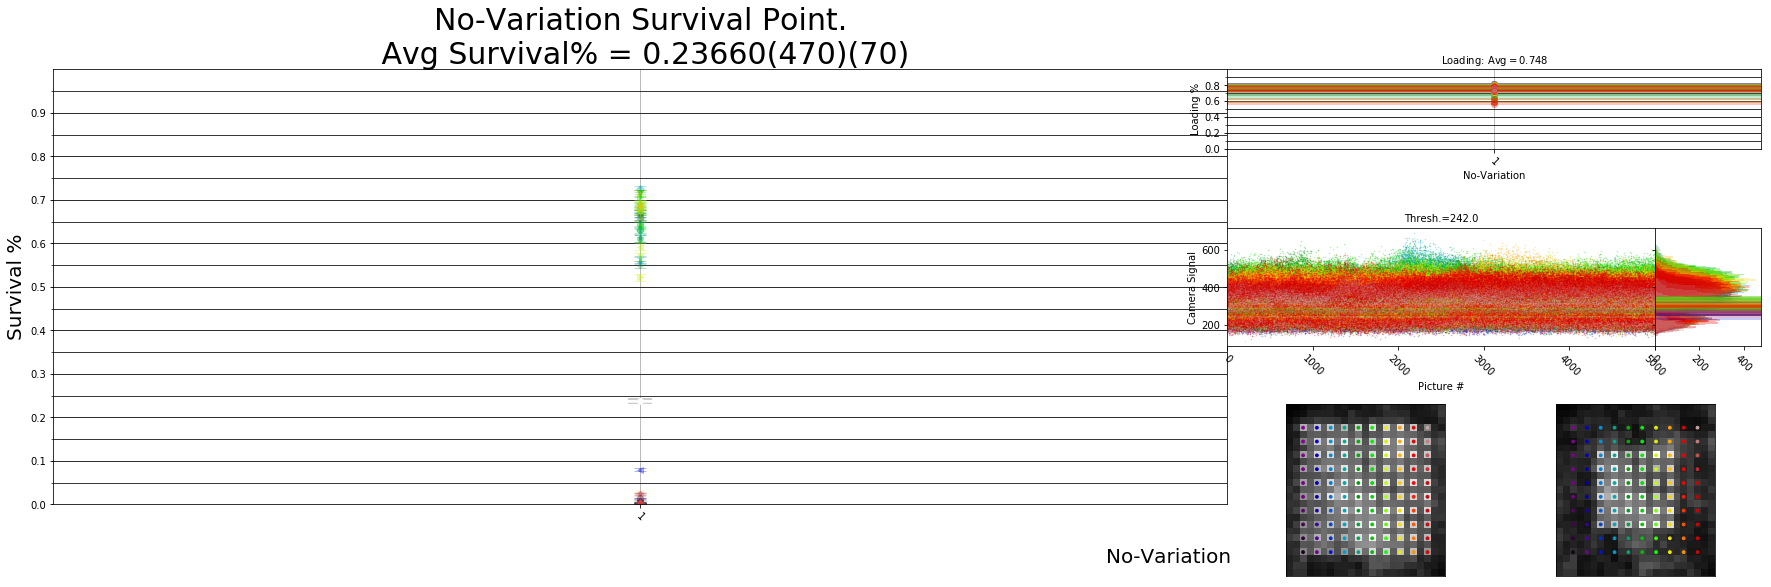

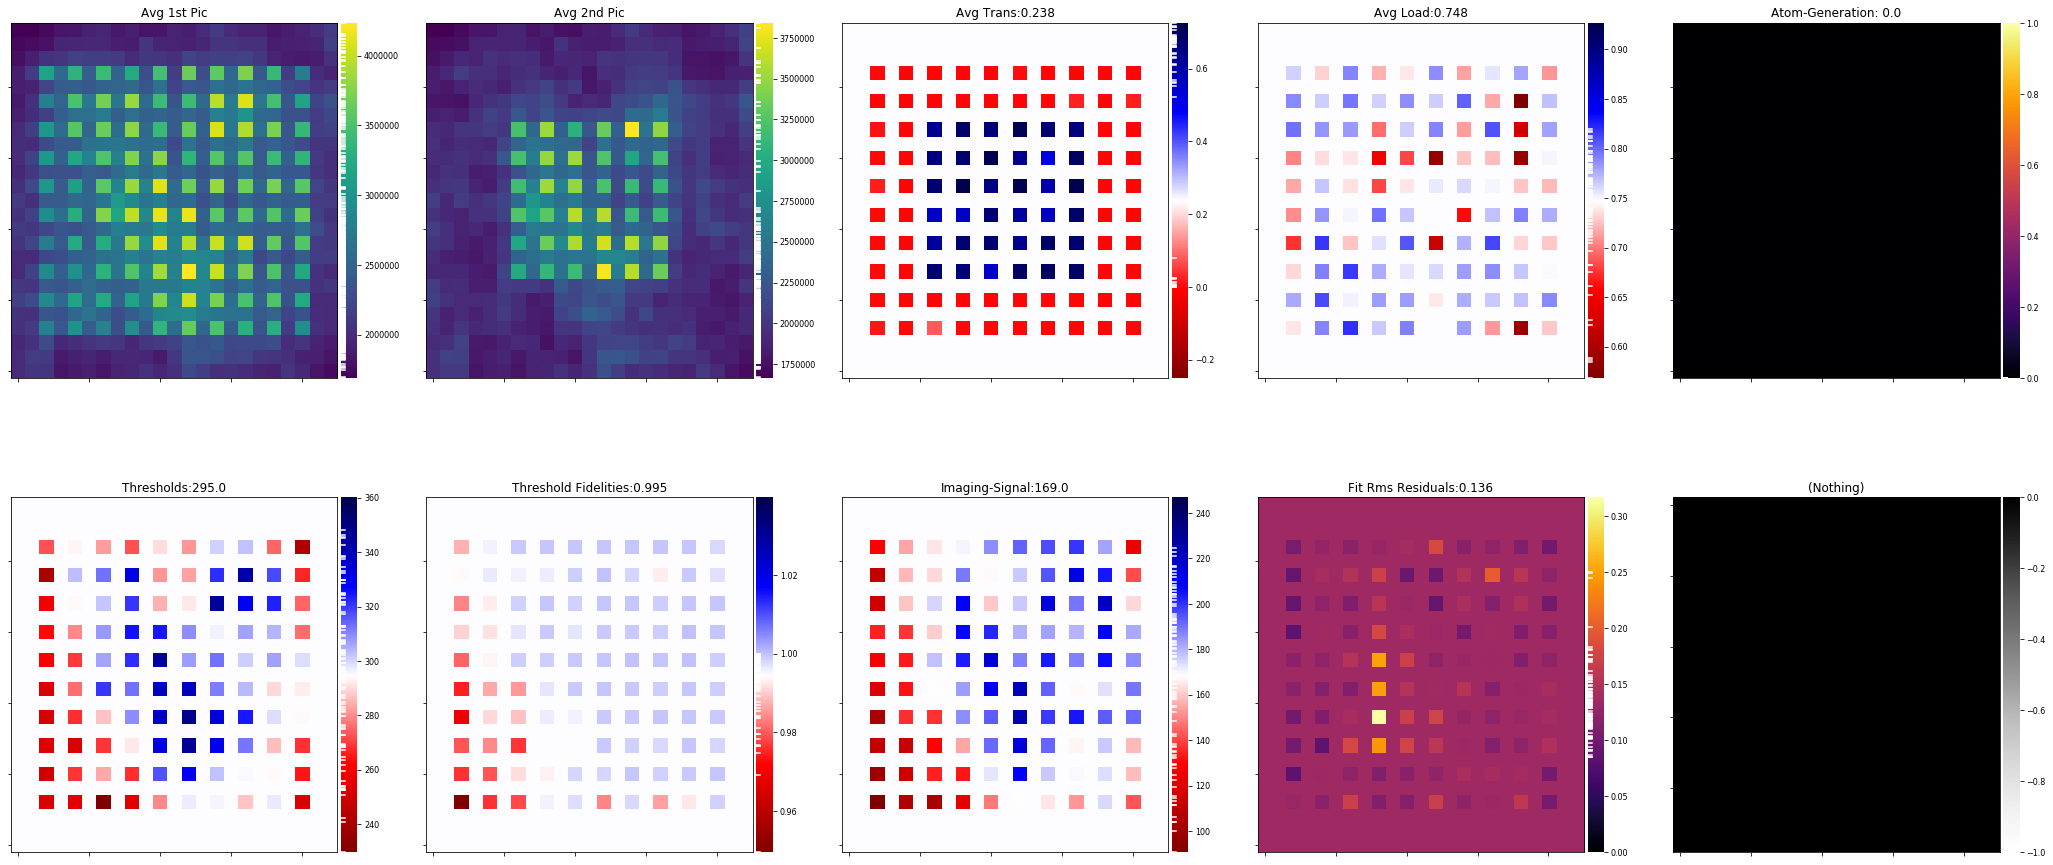

In [271]:
res = mp.Survival(rerng_exp_file, [3,2,2,10,10], subtractEdgeCounts=False, transThresholdSame=True);
( key, transferData, transferErrs, loadingRate, fits, avgFit, genAvgs, genErrs, pic1Data, 
  centers, avgTransferPic, transVarAvg, transVarErr, avgTransferData, avgTransferErr,
  loadAtomImages, transAtomImages, pic2Data, loadThresholds, transThresholds) = res

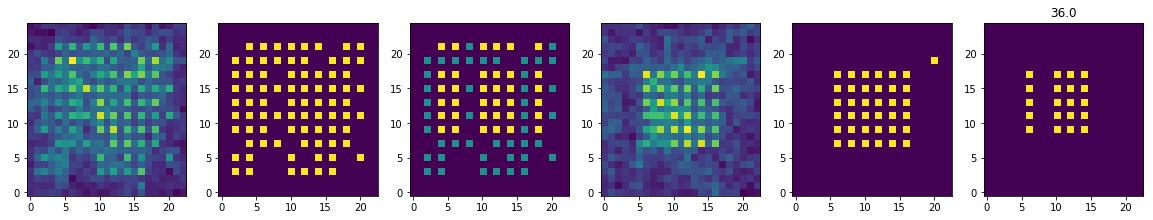

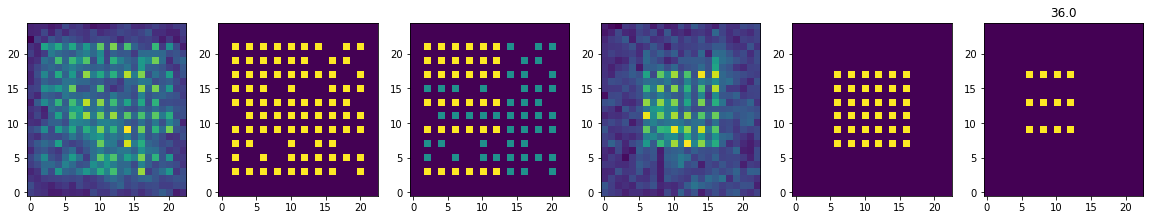

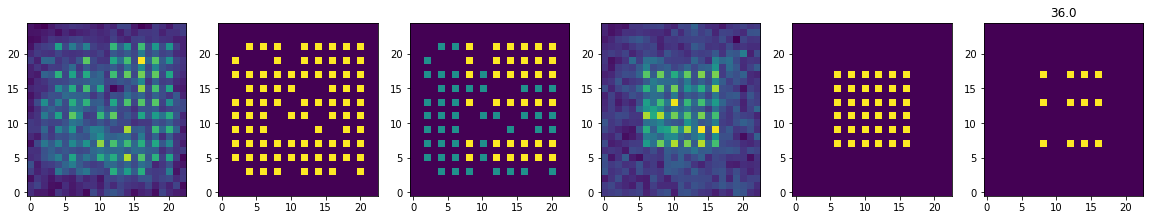

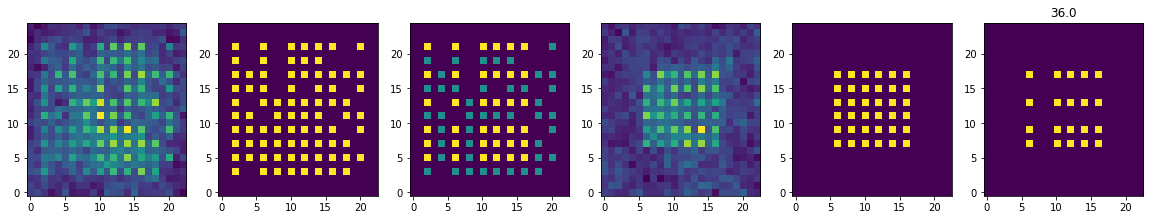

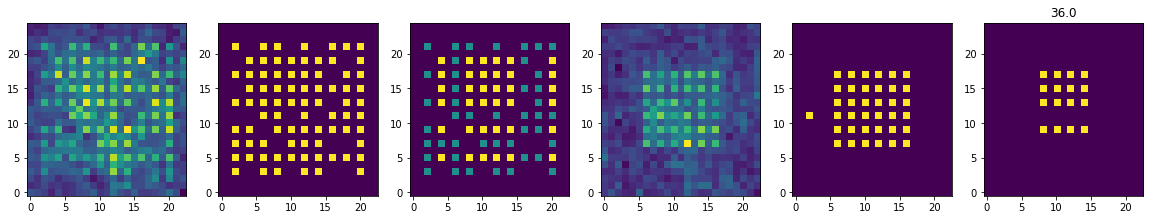

In [307]:
with exp.ExpFile(rerng_exp_file) as f:
    pics = f.get_pics()
count25 = 0
survivalList=[]
nomatch = 0
rerngSize = 6
finArray = np.zeros((25,23))
finlocs = ah.unpackAtomLocations([7,6,2,6,6])
for l in finlocs:
    finArray[l[0],l[1]] = 1
initPics36 = []
finPics36 = []
atomizedPics36 = []
finAtomized36 = []
initAtomized=[]
    
with open(rerng_moves_record) as f:
    for i, l in enumerate(f.readlines()[:]):
        if i < rerngSize+2:
            continue
        ln = i-rerngSize-2
        if ln % 4 == 0:
            continue
        if ln%4 == 1:
            expnum = int(int(ln)/4)
            sourceStr = l[7:-5]
            for x in [' ',';','\n']:
                sourceStr = sourceStr.replace(x,'')
            source = np.reshape([int(x) for x in sourceStr.split(',')],(10,10))
            sourcem = np.zeros((25,23)).astype(int)
            for i in range(10):
                for j in range(10):
                    if source[i,j]:
                        sourcem[2*i+3,2*j+2] = 1
        if ln%4 == 2:
            yind = [int(x) for x in l[:-3].split(',')]
        if ln%4 == 3:
            xind = [int(x) for x in l[:-3].split(',')]
            if yind == xind == [9,8,7,6,5,4]:
                nomatch += 1
                continue
            subm = np.zeros((25,23)).astype(int)
            for i in range(10):
                for j in range(10):
                    if i in yind and j in xind:
                        subm[2*i+3,2*j+2] = 1
            finNumAtoms = sum((transAtomImages[expnum] * finArray).flatten())
            survivalList.append(finNumAtoms)
            if (finNumAtoms >= 36):
                count25 += 1
                initPics36.append(pics[2*expnum])
                initAtomized.append(loadAtomImages[expnum])
                atomizedPics36.append(loadAtomImages[expnum] + subm)
                finAtomized36.append(transAtomImages[expnum])
                finPics36.append(pics[2*expnum+1])
                if True:
                    f, ax = plt.subplots(1,6, figsize=(20,20))
                    plt.title(finNumAtoms)
                    ax[0].imshow(pics[2*expnum], origin='bottom')
                    ax[1].imshow(loadAtomImages[expnum], origin='bottom')
                    ax[2].imshow(loadAtomImages[expnum] + subm, origin='bottom')
                    ax[3].imshow(pics[2*expnum+1], origin='bottom')
                    ax[4].imshow(transAtomImages[expnum], origin='bottom')
                    ax[5].imshow(transAtomImages[expnum] * subm, origin='bottom')
                    for a in ax:
                        a.grid(False)

### Subtract bckgnd & diff from thresholds

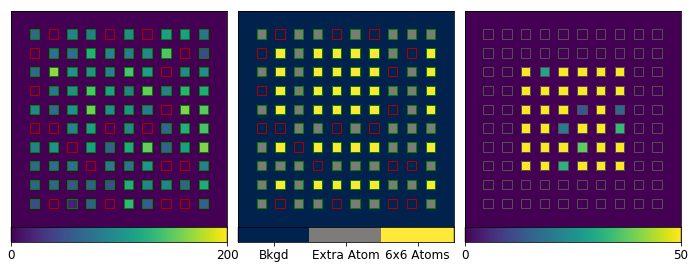

In [703]:
which = -1
fig = plt.figure(figsize=(40,20))
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.15, share_all=True,
                          cbar_location="bottom", cbar_mode="each", cbar_size="7%", cbar_pad="0%" )
numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
fig.set_size_inches([12,12])
init_ = np.zeros(initPics36[0].shape)
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - loadThresholds[i].t 
fin_ = np.zeros(finPics36[which].shape)
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    v = finPics36[which][loc[0],loc[1]] - transThresholds[i].t
    fin_[loc[0],loc[1]] = v
    #if v > 0:
    #    print(loc, v, transThresholds[i].t, finPics36[which][loc[0],loc[1]])

# initAtomized
pics   = [init_, atomizedPics36[which], fin_] 
mins   = [0,0,0]
maxs   = [200,2,50]
cmaps  = ['viridis', mpl.cm.get_cmap('cividis',3), 'viridis']
titles = ['Initial', 'Atomized-Selected', 'Final']

for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics, mins, maxs, cmaps, titles)):
    im = a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        if i < 2:
            color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                  linewidth=1))
        else:
            color = '#505050'
            a.add_patch(plt.Rectangle((loc[1] - 0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1 ))
    cb = grid.cbar_axes[i].colorbar(im)
    if i is 1:
        cb.ax.set_xticks([1/3,1,5/3])
        cb.ax.set_xticklabels(['Bkgd','Extra Atom','6x6 Atoms'], fontsize=12)
    else:
        cb.ax.set_xticks([_min,_max])
        cb.ax.set_xticklabels([_min,_max],fontsize=12)
plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

### subtract avg threshold from bckgnd

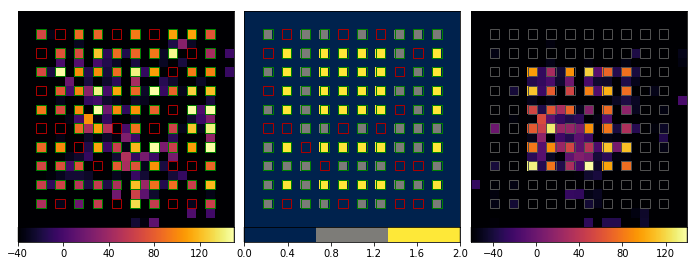

In [704]:
#for which in range(5):
which = -1
fig = plt.figure(figsize=(40,20))
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.15, share_all=True,
                          cbar_location="bottom", cbar_mode="each", cbar_size="7%", cbar_pad="0%" )
numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
fig.set_size_inches([12,12])
init_ = np.zeros(initPics36[0].shape)
thresholdInc = 0
avgThresh = 0
for thresh in loadThresholds:
    avgThresh += thresh.t
avgThresh /= 100
for loc in ah.unpackAtomLocations([0,0,1,23,25]):
    if loc in ah.unpackAtomLocations([3,2,2,10,10]):
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - loadThresholds[thresholdInc].t 
        thresholdInc += 1
    else:
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - avgThresh
fin_ = np.zeros(finPics36[0].shape)
thresholdInc=0
for loc in ah.unpackAtomLocations([0,0,1,23,25]):
    if loc in ah.unpackAtomLocations([3,2,2,10,10]):
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]] - loadThresholds[thresholdInc].t 
        thresholdInc += 1
    else:
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]] - avgThresh
    #if v > 0:
    #    print(loc, v, transThresholds[i].t, finPics36[which][loc[0],loc[1]])

# initAtomized
pics   = [init_, atomizedPics36[which], fin_] 
mins   = [-40,0,-60]
maxs   = [150,2,140]
cmaps  = ['inferno', mpl.cm.get_cmap('cividis',3), 'inferno']
titles = ['Initial', 'Atomized-Selected', 'Final']

for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics, mins, maxs, cmaps, titles)):
    im = a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        if i < 2:
            color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                  linewidth=1))
        else:
            color = '#505050'
            a.add_patch(plt.Rectangle((loc[1] - 0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1 ))
    cb = grid.cbar_axes[i].colorbar(im)
    continue
    if i is 1:
        cb.ax.set_xticks([1/3,1,5/3])
        cb.ax.set_xticklabels(['Bkgd','Extra Atom','6x6 Atoms'], fontsize=12)
    else:
        cb.ax.set_xticks([_min,_max])
        cb.ax.set_xticklabels([_min,_max],fontsize=12)
#plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


### Plain

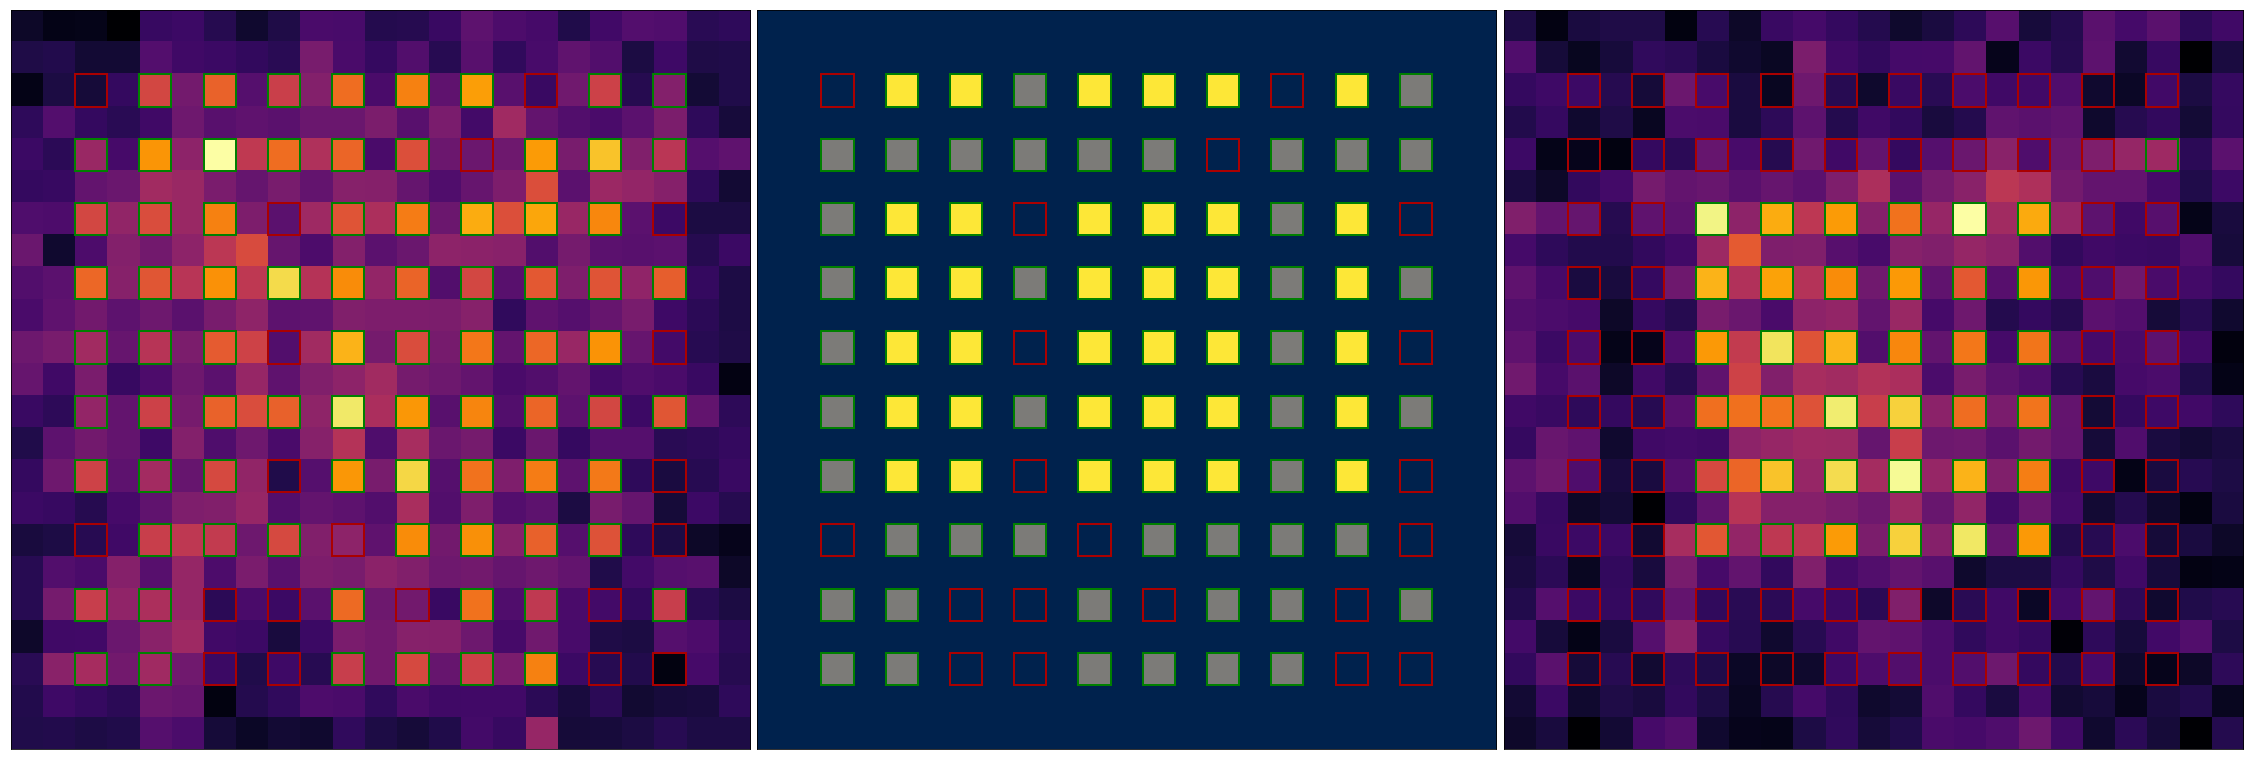

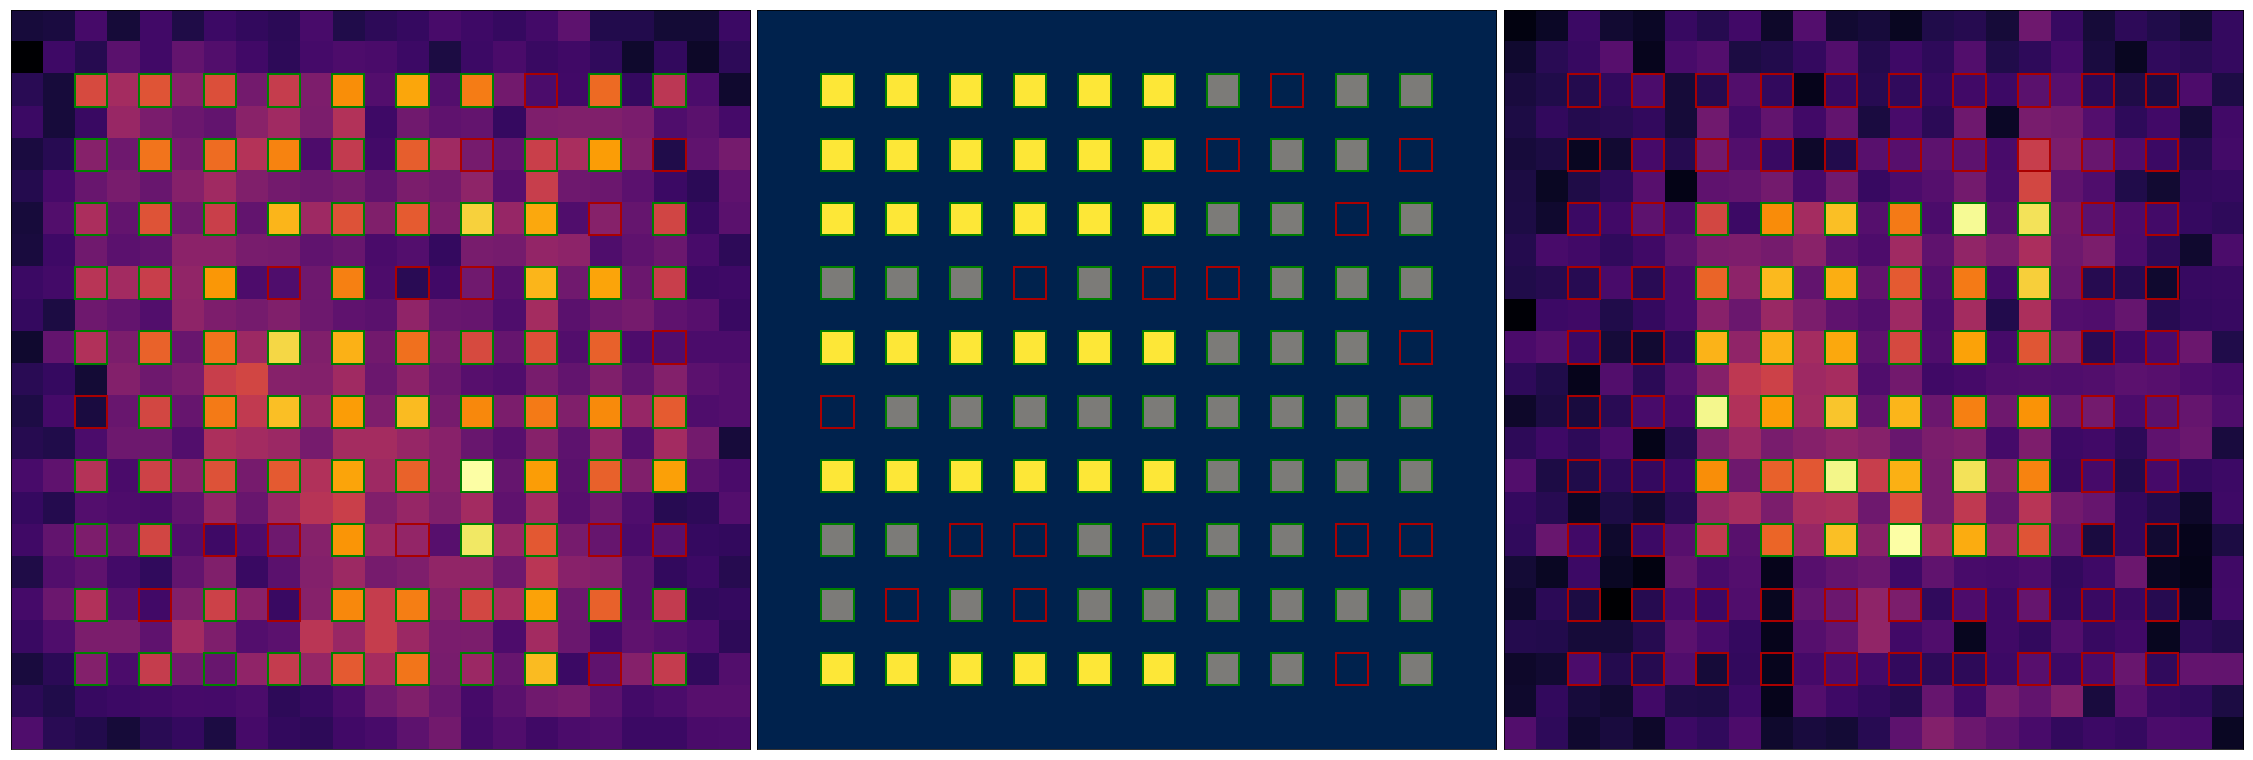

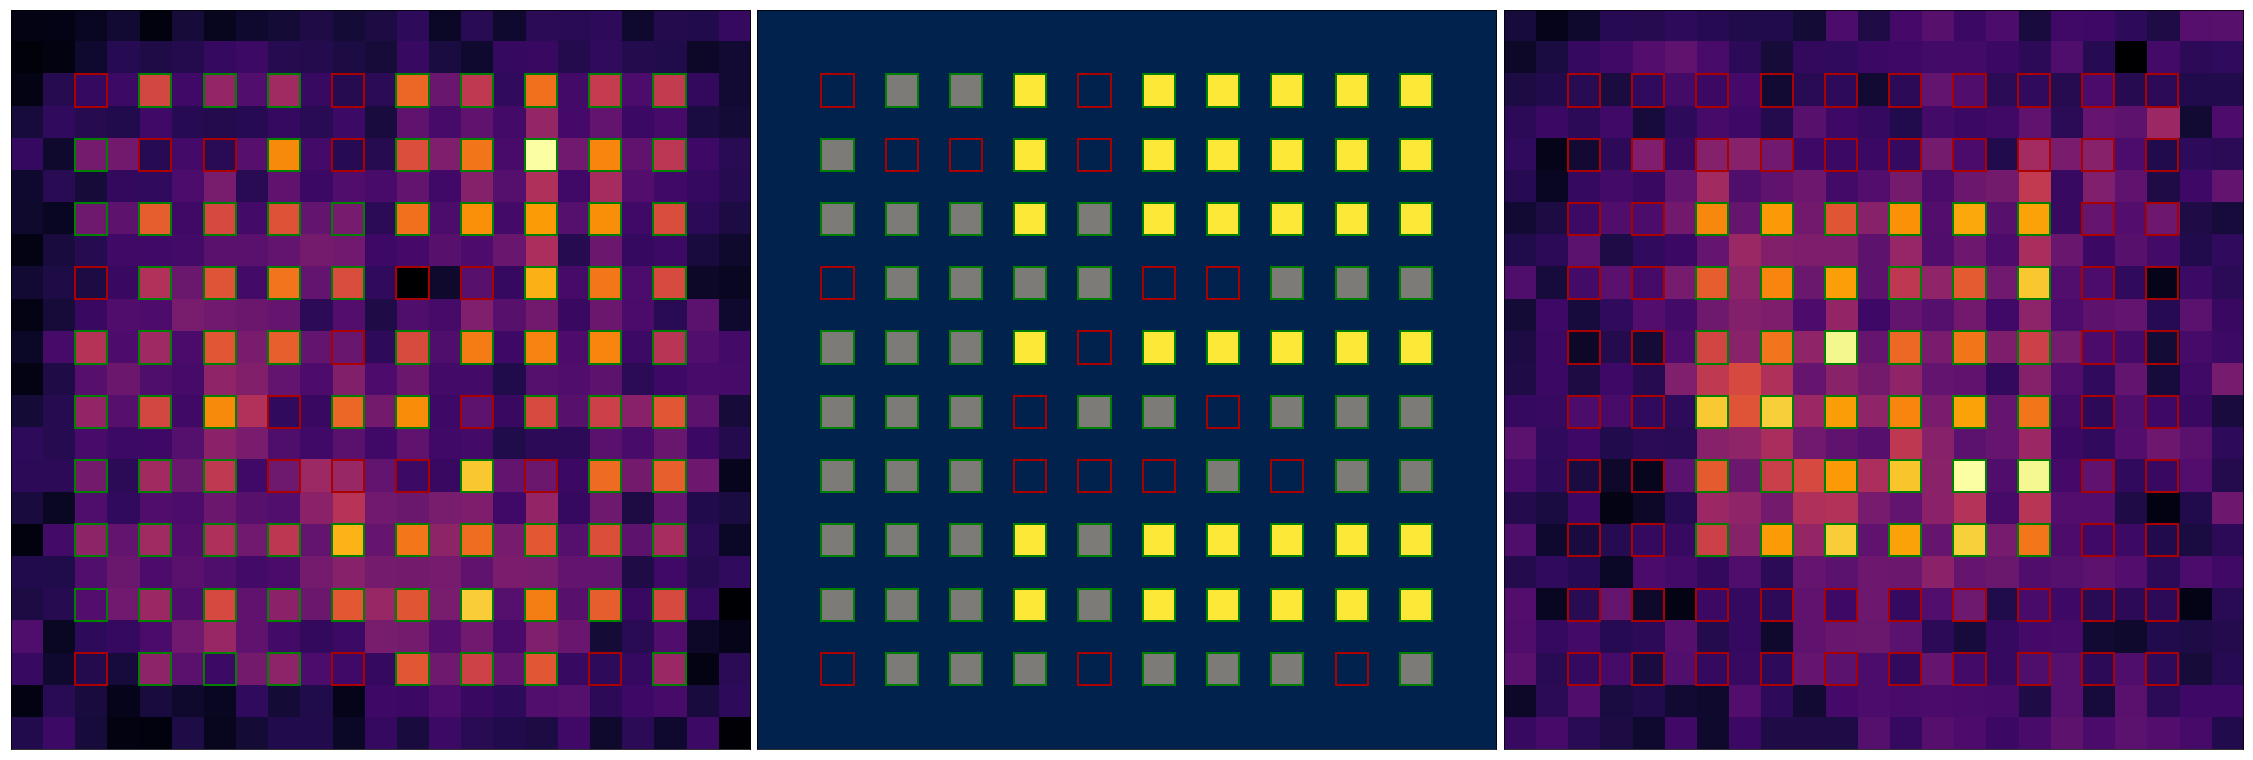

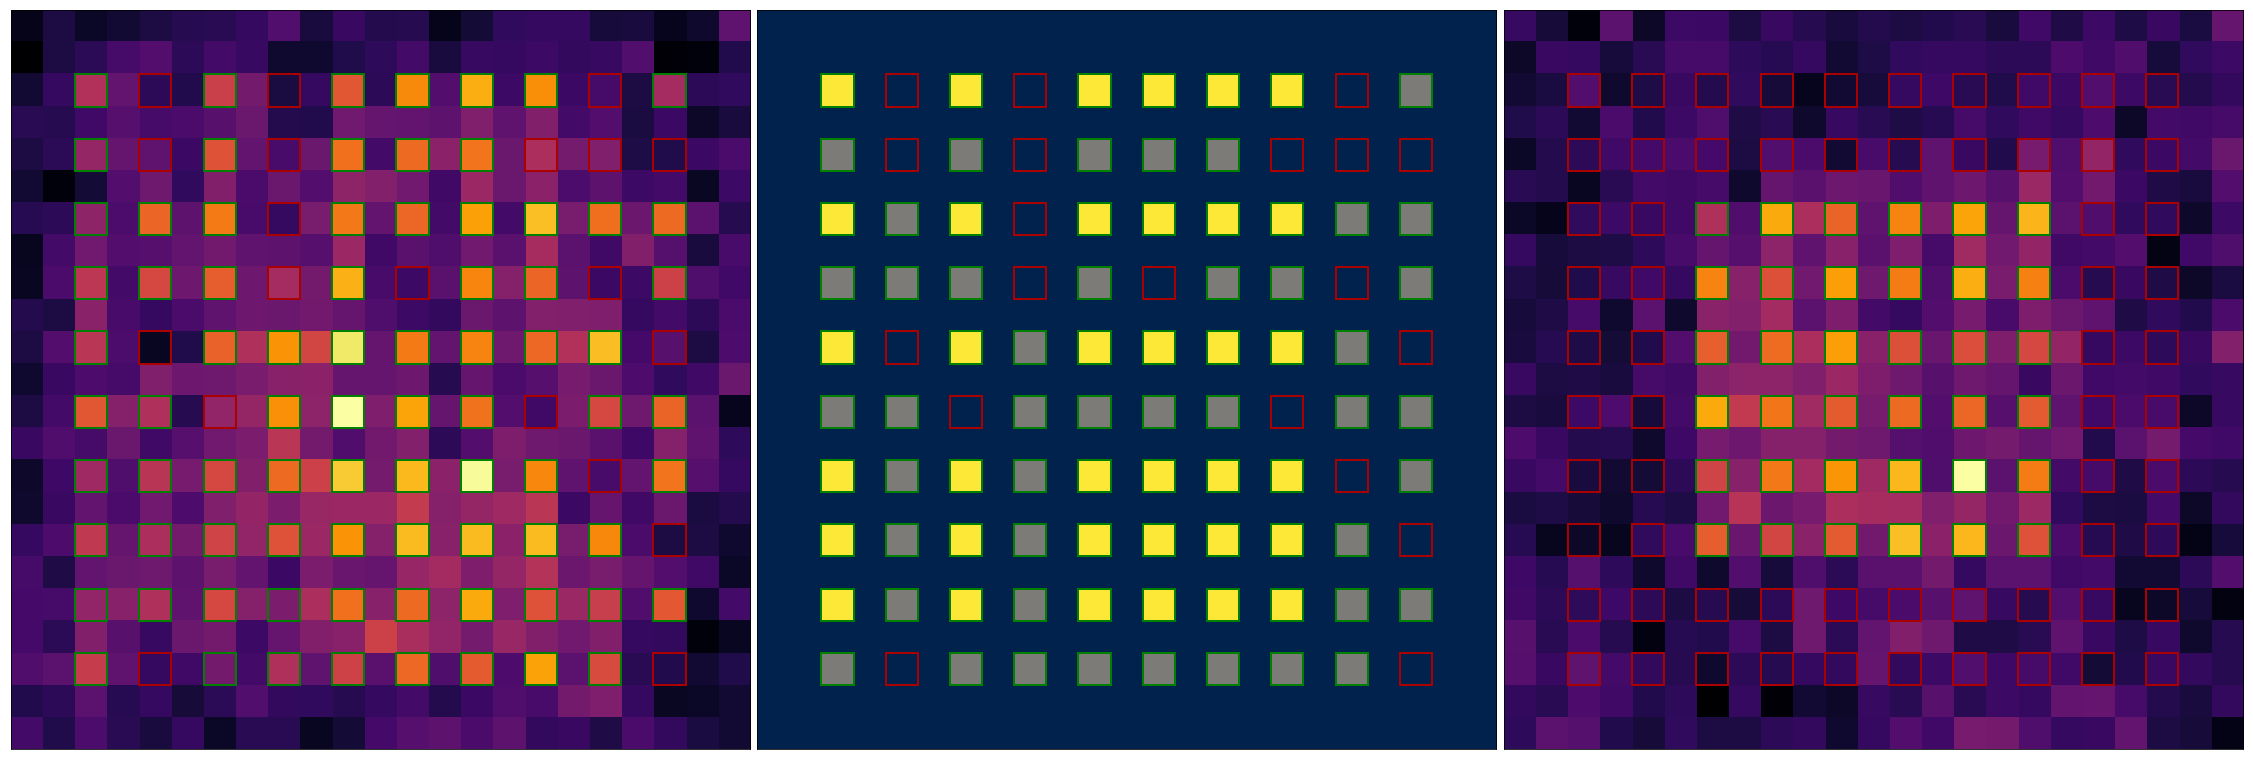

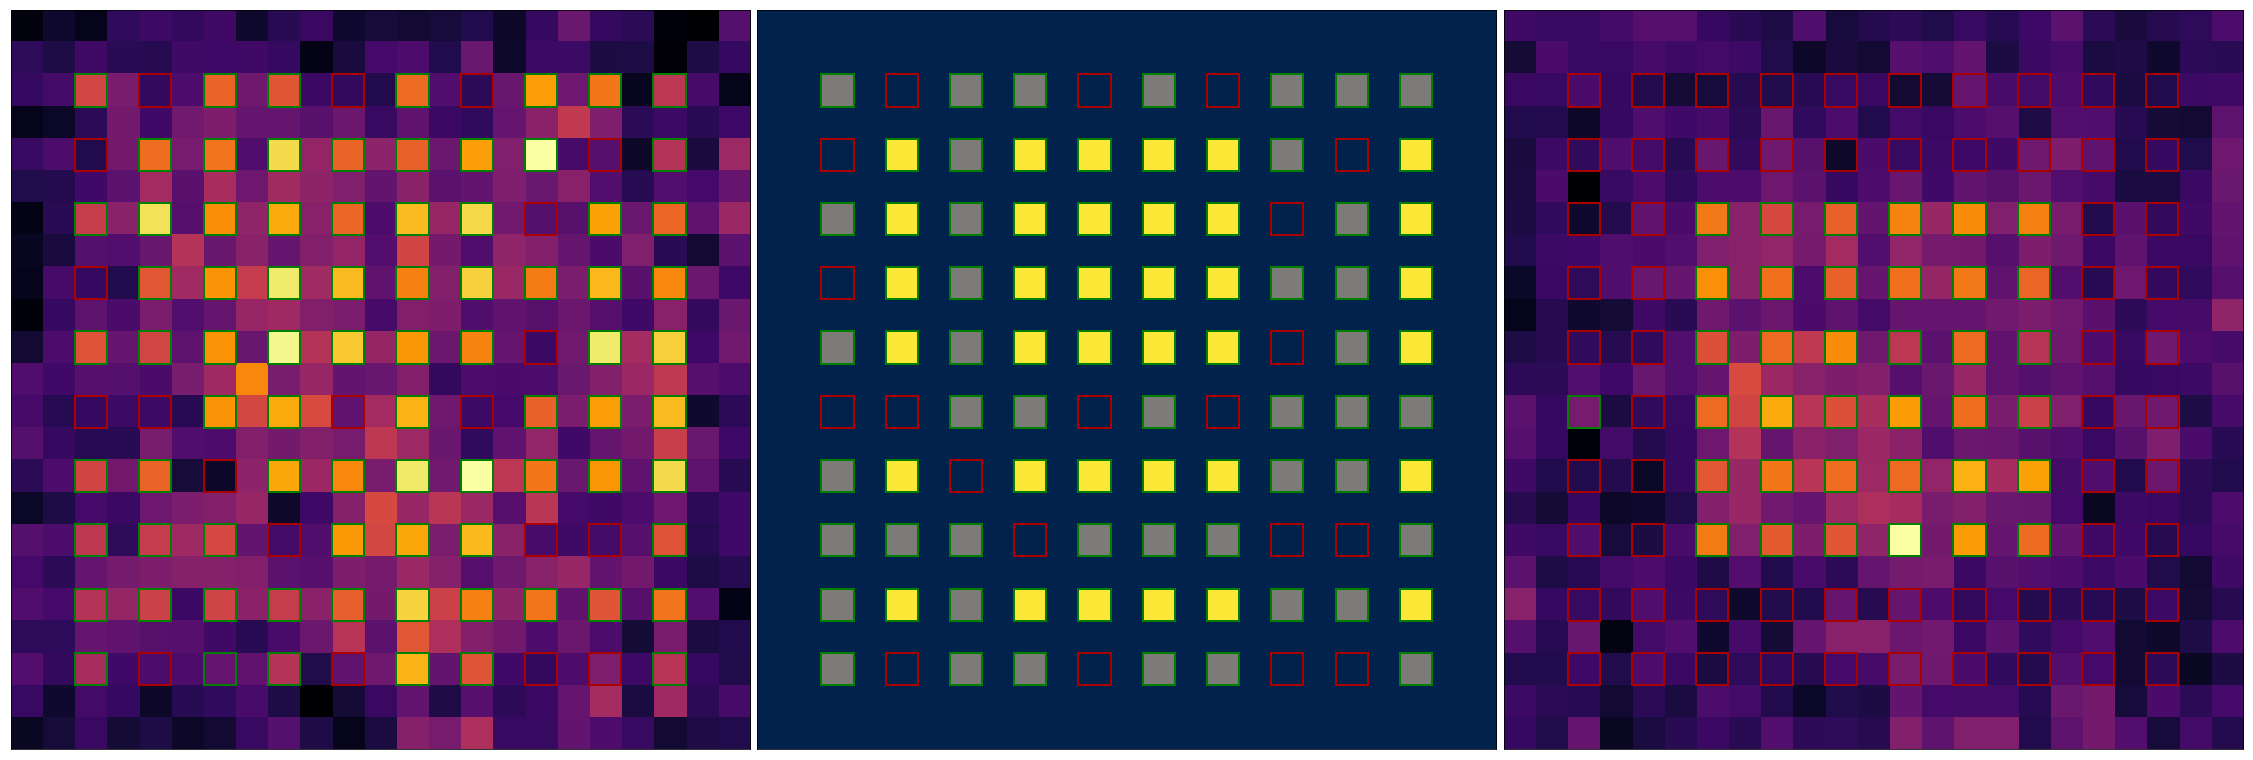

In [702]:
for which in range(5):
    fig = plt.figure(figsize=(40,20))
    grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.1, share_all=True)
    cmaps=['inferno', 'cividis', 'inferno']
    numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
    titles = ['Initial', 'Atomized-Selected', 'Final']
    #fig.set_size_inches([9,9])
    pics_ = [initPics36[which], atomizedPics36[which], finPics36[which]] # initAtomized
    mins = [None,0,None]
    maxs = [None,2,None]
    for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics_, mins, maxs, cmaps, titles)):
        a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            if i < 2:
                color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
            else:
                color = 'g' if finAtomized36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
    #plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

### just subtract background

In [574]:
mc.h *20e6

1.325214e-26

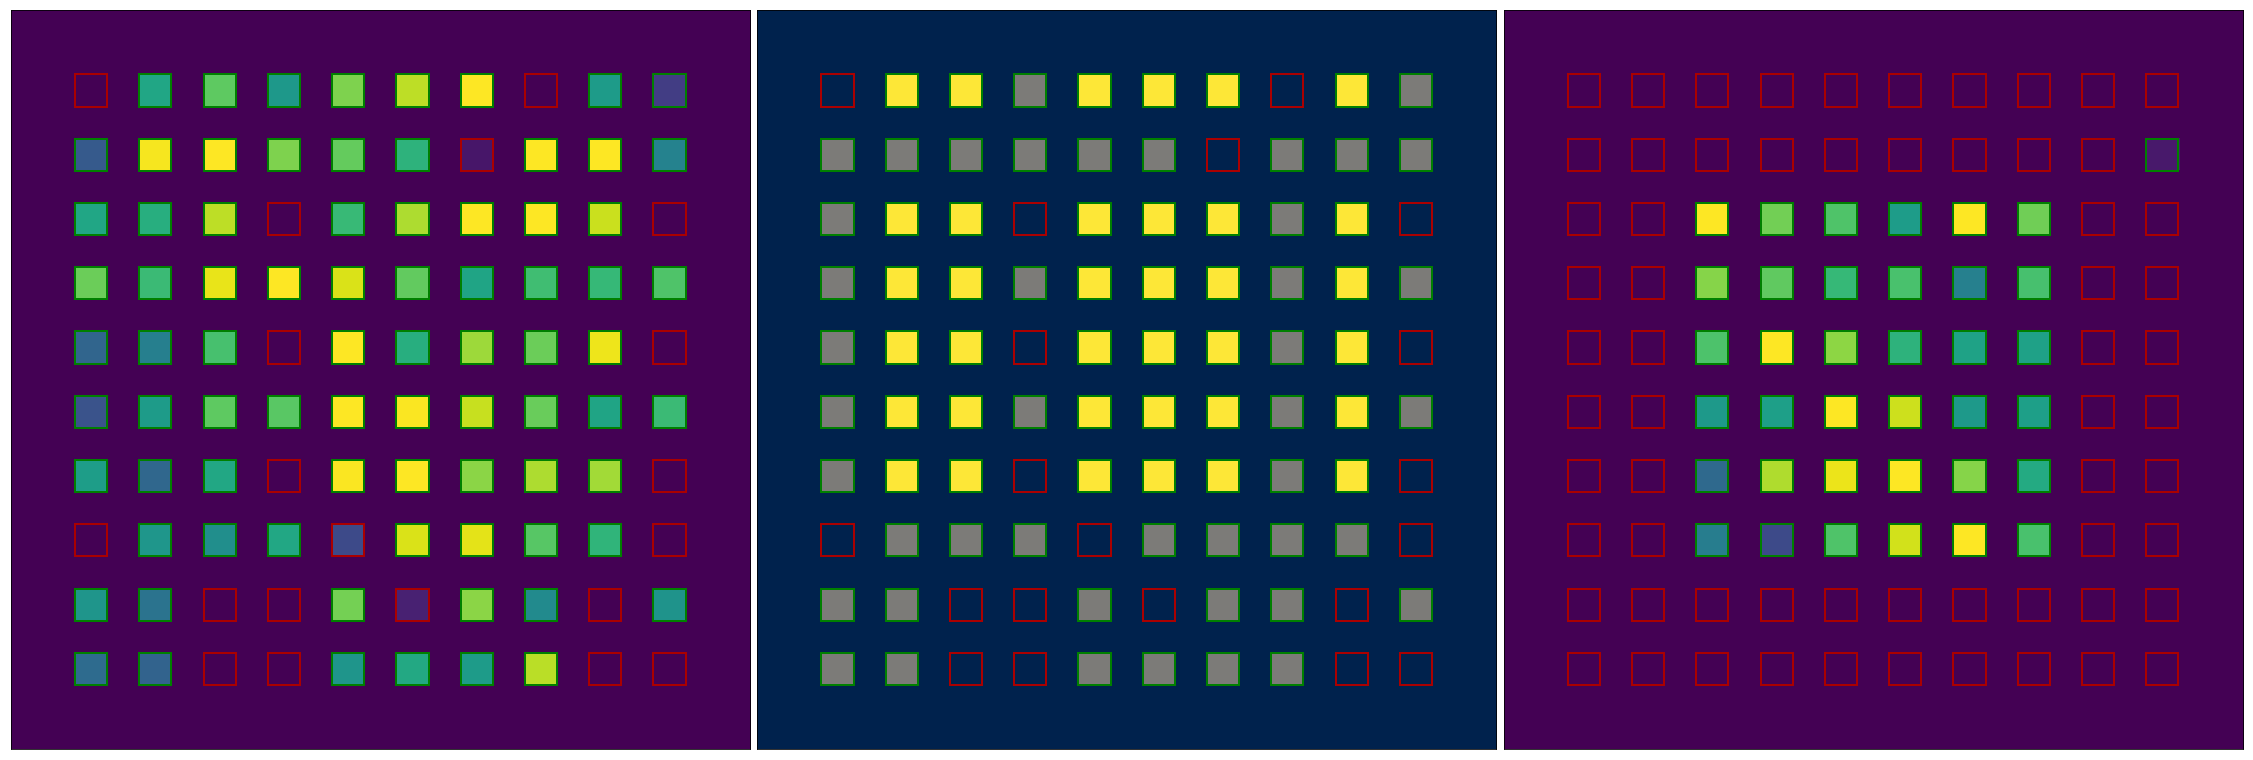

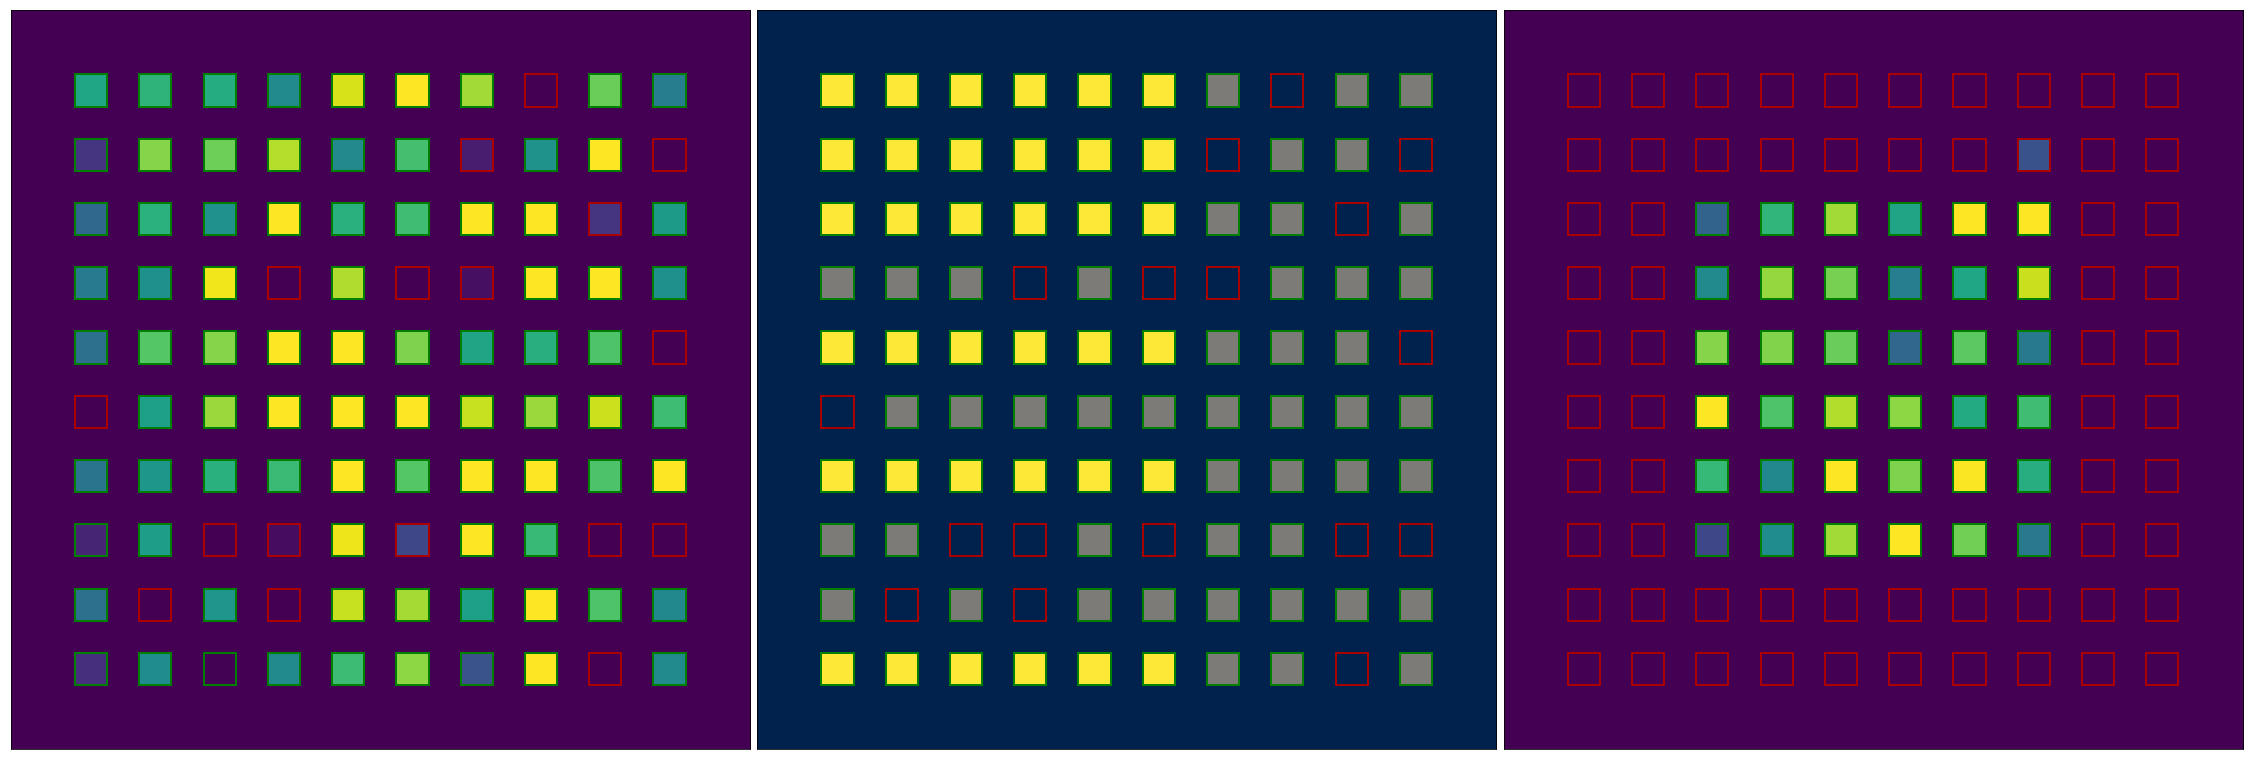

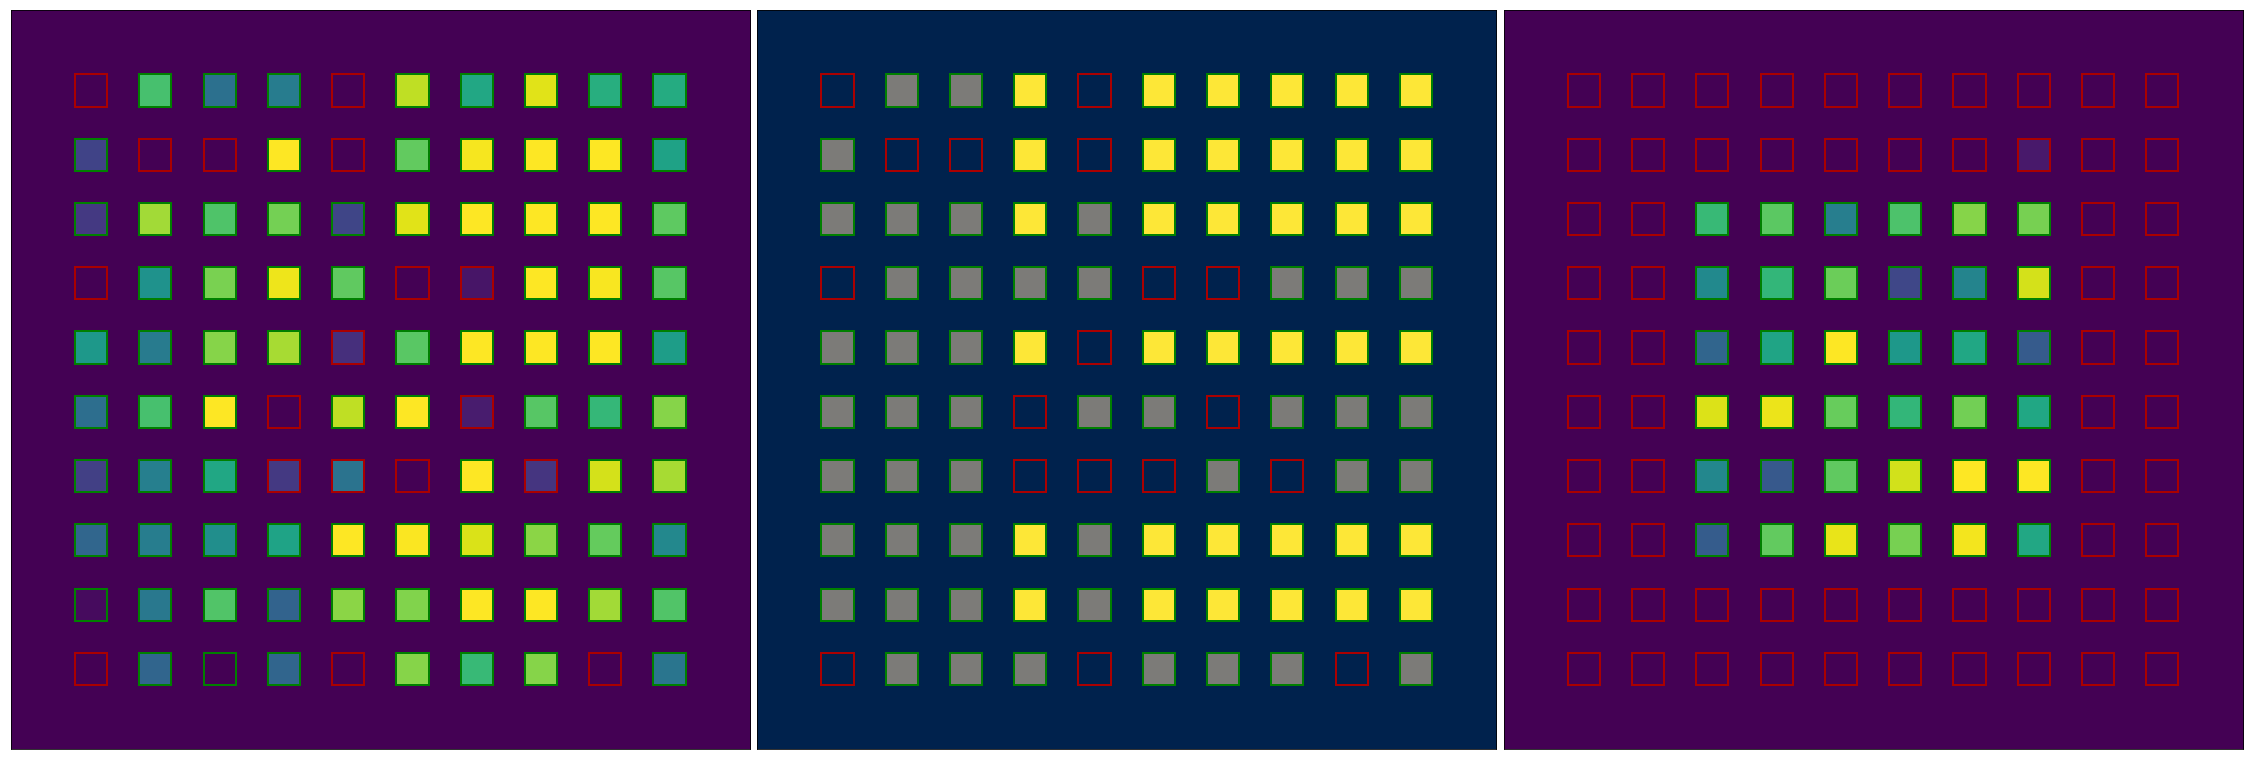

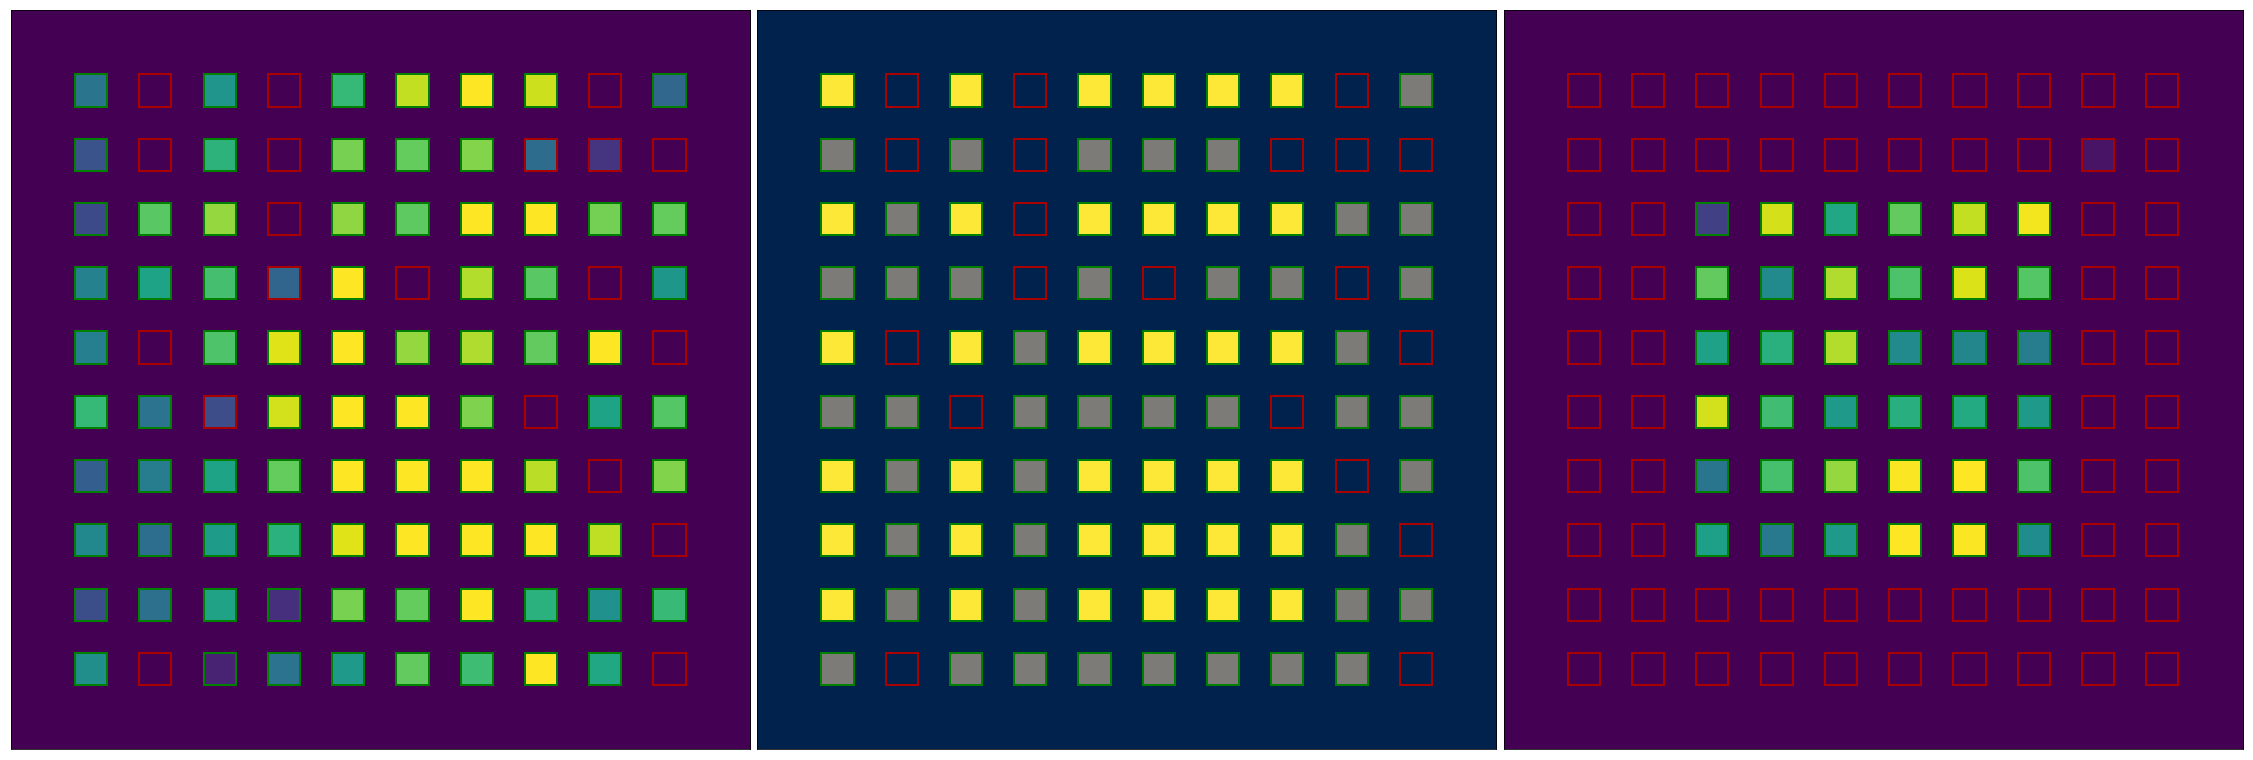

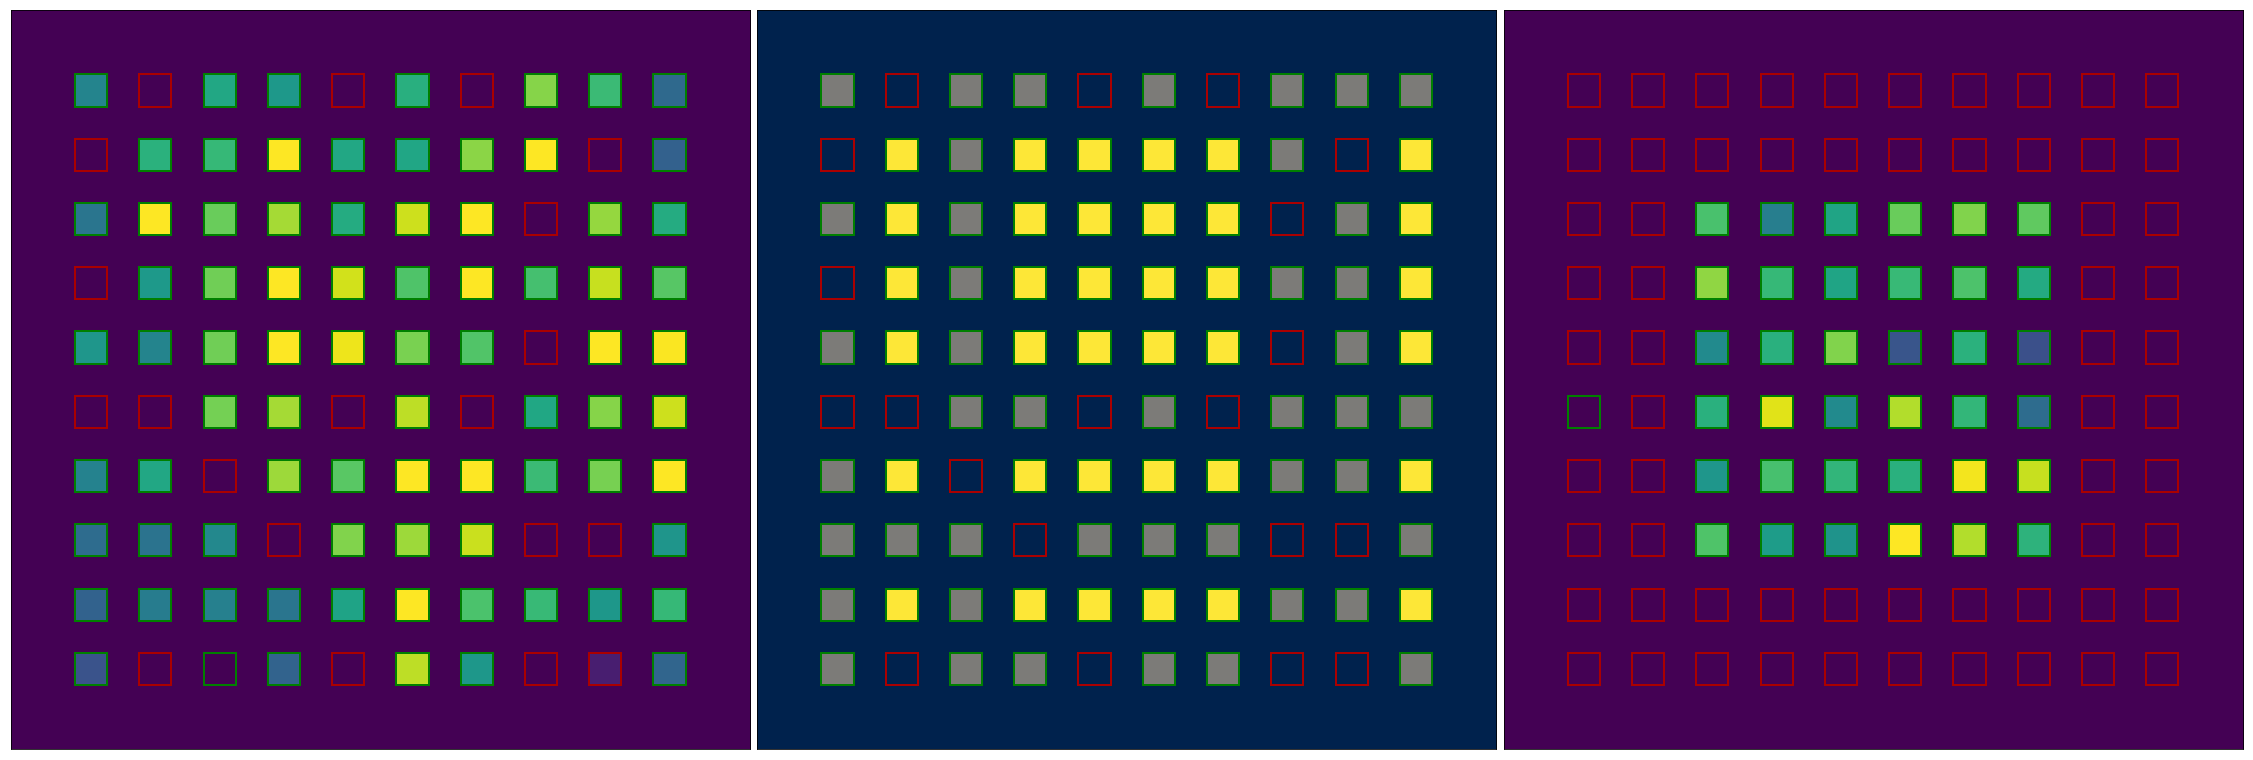

In [312]:
for which in range(5):
    fig = plt.figure(figsize=(40,20))
    grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.1, share_all=True)
    cmaps=['viridis', 'cividis', 'viridis']
    numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
    titles = ['Initial', 'Atomized-Selected', 'Final']
    #fig.set_size_inches([9,9])
    init_ = np.zeros(initPics36[0].shape)
    for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]]# - loadThresholds[i].t  # loadThresholds, transThresholds
    fin_ = np.zeros(finPics36[which].shape)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]]#- loadThresholds[i].t
    pics_ = [init_, atomizedPics36[which],fin_] # initAtomized
    mins = [250, 0, 275]
    maxs = [450, 2, 450]
    for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics_, mins, maxs, cmaps, titles)):
        a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            if i < 2:
                color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
            else:
                color = 'g' if finAtomized36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
        #plt.savefig('rerng_sequence_'+str(i)+'.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)
    #plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

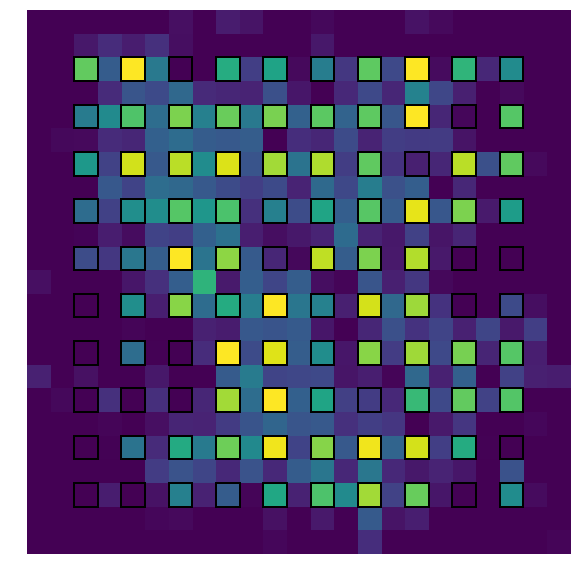

In [206]:
plt.figure(figsize=(10,10))
plt.imshow(rawData[5702][1:24,:], vmin=225, vmax=475, origin='bottom', cmap='viridis', zorder=1)

currentAxis = plt.gca()
for loc in ah.unpackAtomLocations([3,2,2,10,10]):
    currentAxis.add_patch(plt.Rectangle((loc[0]-1.5, loc[1]-0.5),1,1, zorder=2, facecolor='none', edgecolor='k', 
                                       linewidth=2))
plt.axis('off');
plt.savefig('80_Atoms.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

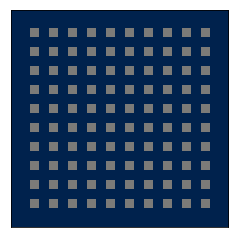

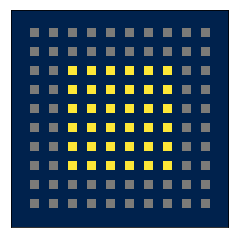

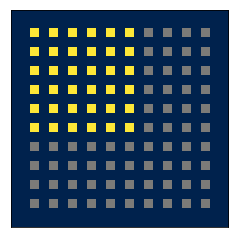

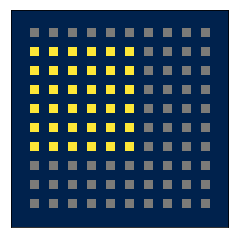

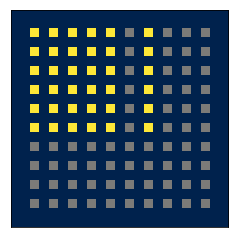

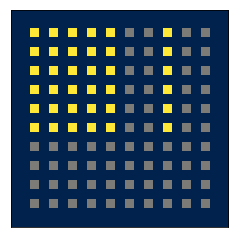

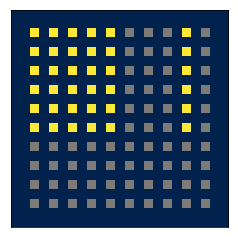

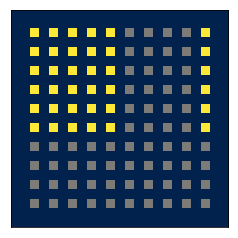

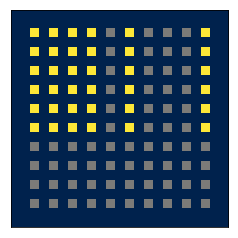

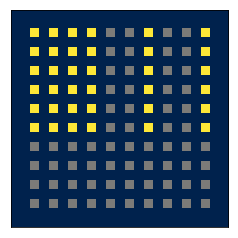

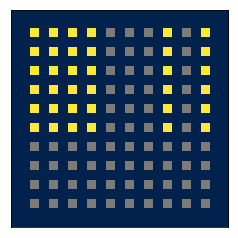

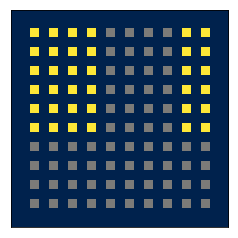

In [209]:
basepic = np.zeros((23,23))
for loc in ah.unpackAtomLocations([2,2,2,10,10]):
    basepic[loc[0]][loc[1]] += 1    
plt.figure()
plt.imshow(basepic, vmin=0, vmax=2, cmap='cividis')
plt.xticks([])
plt.yticks([])
plt.savefig('Stiff_Configs_base.png',transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

locSets = [[6,6,2,6,6], [2,2,2,6,6], [4,2,2,6,6]]
locSets =  [ah.unpackAtomLocations(locs) for locs in locSets]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,14,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,16,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,18,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,12,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,14,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,16,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,18,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
for i, locs in enumerate(locSets):
    newpic = copy(basepic)
    for loc in locs:
        newpic[loc[0]][loc[1]] += 1
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(newpic, vmin=0, vmax=2, cmap='cividis')
    plt.savefig('Stiff_Configs_' + str(i) + '.png',transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

In [210]:
print(count25, count25/(len(pics)/2)*100, nomatch/(len(pics)/2))

7 466.6666666666667 2690.6666666666665


In [211]:
0.90**36 * 0.19 * 100

0.42803959135384473

In [212]:
np.mean(survivalList) / 36

0.72642923005993554

# 1D data cross-section

### single atom options

#### thresholds optimized

In [101]:
repsPerVar = 150
borders = [0,4,7,11,60,290,310,350,400,450,500]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(grey_mol_file) as f:
    kn, key_grey = f.get_key()
# # (to see where I set threshold regions)
# x_i = 0
# for p, t in zip(pixels, thresh):
#     plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#     hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#     x_i += len(p)
avg_combined_grey = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_grey += l
    errsCombined += e
key1_1, key2_1 = key_grey[:,0], key_grey[:,1]
key1_1 = np.sort(np.unique(key1_1))
key2_1 = np.sort(np.unique(key2_1))
im_2dscan_1 = np.zeros((len(key1_1),len(key2_1)))
err_2d_1 = [[[] for _ in key1_1] for _ in key2_1] #np.zeros((len(key1_1), len(key2_1)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_1==keyVal[0])[0][0]
    i2 = np.where(key2_1==keyVal[1])[0][0]
    im_2dscan_1[i2,i1] = avg_combined_grey[i]
    err_2d_1[i2][i1] = jeffreyInterval(avg_combined_grey[i],150)#errsCombined[i]

#single_atom_analysis(None, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True, data=avg_combined_grey, err=errsCombined, key=key_grey, units='grey')
"""
file = None
title='cross-section'
units = 'grey'
showVals = False
realsize=True
save=False
key=key_grey
data=avg_combined_grey
err=errsCombined

if file is not None:
    res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
    ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
    avgLoading = avgLoading[0]
    avgLoadingErr = avgLoadingErr[0]
else:
    avgLoading = data
    avgLoadingErr = err
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
im_2dscan = np.zeros((len(key1),len(key2)))
err_2d = np.zeros((len(key1), len(key2)))
for i, keyVal in enumerate(key):
    i1 = np.where(key1==keyVal[0])[0][0]
    i2 = np.where(key2==keyVal[1])[0][0]
    im_2dscan[i2,i1] = avgLoading[i]
    err_2d[i2,i1] = avgLoadingErr[i]
f, ax = plt.subplots(4,6,figsize=(40,20))
scaledKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
for i, (d, e, a) in enumerate(zip(im_2dscan, err_2d, ax.flatten())):
    a.errorbar(scaledKey, d * 100, yerr=e*100,ls='', marker='o', capsize=3, 
               label=misc.round_sig_str(TweezerPowerToDepth.f(key2[i])) + 'mK')
    plt.sca(a)
    plt.grid(True)
    plt.xticks(scaledKey[::3], rotation=25);
    plt.yticks(np.arange(0,110,10));
    plt.xlabel('Cooling-Beam Frequency')
    plt.ylabel('Loading %')
    plt.legend()
plt.savefig('Single_Atom_Slices.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
"""
"""
divider = axesTool.make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.0)    
cb = f.colorbar(im, cax, orientation='vertical');
cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
""";

### 10x10 options

thresholds optimized

In [423]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False
save=True
key=None
data=None
err=None
repsPerVar = 100
borders = [int(x) for x in np.linspace(0,484,20)]
errs, pixels, thresh, data = [[[None for _ in range(len(borders)-1)] for _ in range(100)] for _ in range(4)]
for bi in range(len(borders)-1):
    print('.',end='')
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(file, [3,2,2,10,10], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    for ai in range(100):
        errs[ai][bi], thresh[ai][bi], pixels[ai][bi], data[ai][bi] = res[4][ai], res[1][ai], res[0][ai], res[5][ai]
with exp.ExpFile(file) as f:
    kn, key = f.get_key()
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2 = [k for k in key2 if k <= 205]
optData = [[] for _ in range(100)]
optErrs = [[] for _ in range(100)]
for atomInc in range(100):
    for borderInc in range(len(data[atomInc])):
        optData[atomInc] += data[atomInc][borderInc]
        optErrs[atomInc] += errs[atomInc][borderInc]
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(optData)]

....

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



...............

In [424]:
print(arr(optData).shape)
# 44 45 54 55
mid2dScans = [np.zeros((len(key2),len(key1))) for _ in range(4)]
err2dScans = [[[[] for _ in key1] for _ in key2] for _ in range(4)]
for j, which in enumerate([44,45,54,55]):
    for i, keyVal in enumerate(key):
        try:
            i1 = np.where(key1==keyVal[0])[0][0]
            i2 = np.where(key2==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        mid2dScans[j][i2,i1] = optData[which][i]
        err2dScans[j][i2][i1] = jeffreyInterval(optData[which][i], 100)#optErrs[which][i]
        # 100 atoms, 100 reps per variation, gives the total rep count here. This is the error averaging over the different atoms.
        #err_2d[i2, i1] = 

(100, 484)
76.00.042.00.078.038.056.074.013.01.077.079.021.020.070.031.09.045.080.00.056.066.05.00.063.00.032.070.079.065.026.00.018.028.08.080.067.057.00.041.035.064.02.05.085.070.040.02.071.044.082.082.067.063.032.070.080.025.013.00.076.046.022.067.075.032.023.07.020.010.07.00.020.082.079.06.047.058.039.065.029.072.033.077.06.09.04.076.023.080.077.082.084.075.081.00.070.076.05.01.017.078.01.039.067.015.047.075.021.076.074.041.01.042.07.055.05.067.059.028.065.02.069.081.033.046.076.023.03.025.075.072.057.039.029.00.00.064.046.031.076.028.06.012.01.068.00.060.00.074.011.076.043.079.09.040.069.015.06.08.03.033.013.045.078.00.028.052.089.011.00.032.010.00.077.075.014.00.072.024.00.00.068.079.071.081.01.025.069.045.04.08.020.03.061.021.057.00.071.018.052.060.061.018.036.042.01.082.070.077.052.05.061.074.082.082.071.00.00.073.081.013.066.021.015.010.075.075.01.00.017.083.011.074.079.025.060.021.067.069.053.01.041.054.011.043.067.077.082.051.085.080.050.02.047.078.03.057.077.083.073.078.00.

7194.037.03799.0134.06605.03307.05220.07765.02336.0231.07377.07124.01682.03720.06167.02773.0780.05482.07781.091.05488.06647.0336.074.06315.055.02495.06840.07860.06274.03188.0159.01392.01827.01126.07421.05575.05042.04.04083.02487.05760.0125.01167.07777.07116.04722.0178.06650.03940.07784.07726.05958.04678.04791.06232.07858.01733.01070.021.07158.03826.02849.06211.06612.03085.02007.0616.02447.0974.01611.035.01475.07809.07840.0783.04014.05921.03673.06661.02320.07206.03082.07321.01130.01141.0234.07862.02640.07082.06794.07456.07804.06757.07446.047.06817.06899.0490.0335.01461.07406.028.03099.06658.0964.04110.07348.02014.06678.06687.04474.031.04599.01147.05255.0253.05911.05815.02302.05183.0122.06659.07630.03866.03775.07230.02141.0287.03042.07614.07259.04957.02742.04565.095.036.06242.03428.02727.07280.02308.01294.01355.0111.06493.014.04656.017.06745.0683.07063.04696.07947.0441.03000.05970.02176.0325.01353.0185.03136.0714.03843.07634.028.02484.04548.07468.0472.021.02736.0923.069.07098.06545.0805.

<Figure size 306x306 with 0 Axes>

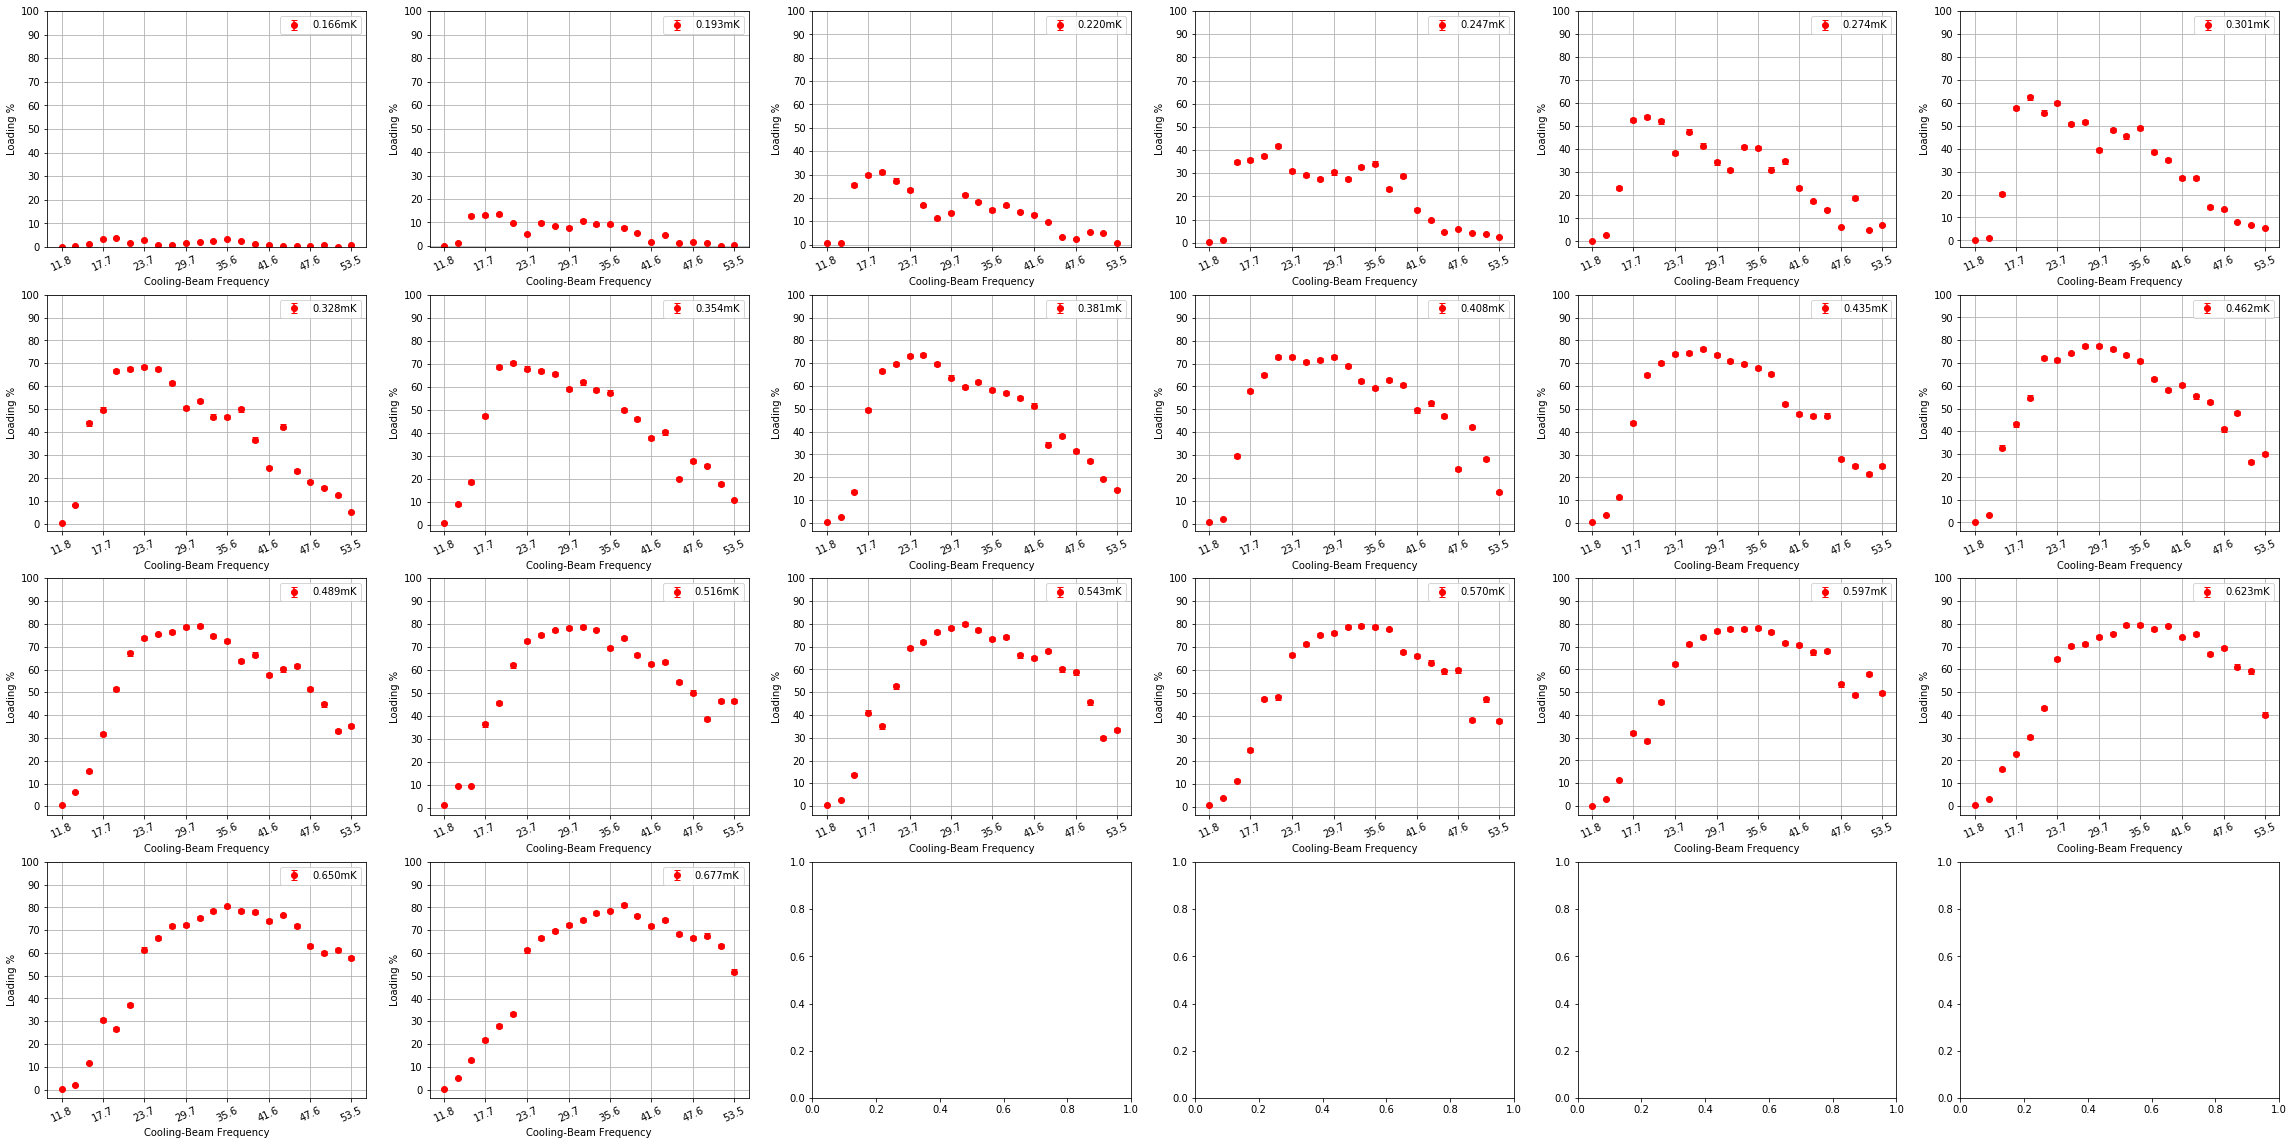

In [431]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
im_2dscan = np.zeros((len(key2),len(key1)))
err_2d = [[[] for _ in key1] for _ in key2]#np.zeros((len(key2),len(key1)))
for i, keyVal in enumerate(key):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    av = avgAvgLoading[i]
    im_2dscan[i2,i1] = av
    # 100 atoms, 100 reps per variation, gives the total rep count here. This is the error averaging over the different atoms.
    err_2d[i2][i1] = jeffreyInterval(av, 100*100) #np.sqrt(av*(1-av))/np.sqrt(100*100)

f, ax = plt.subplots(4,6,figsize=(40,20))
scaledKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
for i, (d, a) in enumerate(zip(im_2dscan, ax.flatten())):
    a.errorbar(scaledKey, d * 100, yerr=arr(misc.transpose(err_2d[i]))*100,ls='', marker='o', capsize=3, 
               label=misc.round_sig_str(TweezerPowerToDepth.f(key2[i])/100.0) + 'mK', color='r')
    plt.sca(a)
    plt.grid(True)
    plt.xticks(scaledKey[::3], rotation=25);
    plt.yticks(np.arange(0,110,10));
    plt.xlabel('Cooling-Beam Frequency')
    plt.ylabel('Loading %')
    plt.legend()
plt.savefig('10x10_Slices.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

### Overlaping plot

In [ ]:
confidenceInterval()

In [828]:
from statsmodels.stats.proportion import proportion_confint as confidenceInterval
def jeffreyInterval(m,num):
    print(round(m*num),end='')
    i1, i2 = confidenceInterval(round(m*num), num, method='jeffreys')
    return (m - i1, i2 - m)

In [829]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

0.55
0.54


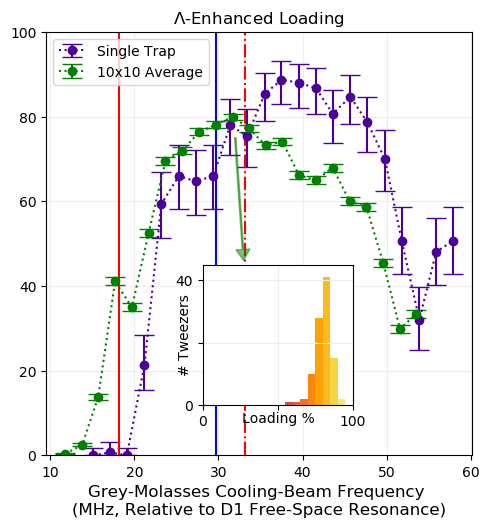

In [837]:
which10 = 14
which1=7
scaledKey_1 = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_1]
fig, a = plt.subplots(1,1)
fig.set_size_inches(5.5,5.5)
print(misc.round_sig_str(TweezerPowerToDepth.f(key2_1[which1]),2))
print(misc.round_sig_str(TweezerPowerToDepth.f(key2[which10])/100.0,2))
a.errorbar( scaledKey_1, im_2dscan_1[which1]*100, yerr=arr(misc.transpose(err_2d_1[which1]))*100,ls=':', marker='o', capsize=7,
              label='Single Trap',color='#4C0099' )
a.errorbar( scaledKey, im_2dscan[which10] * 100, yerr=arr(misc.transpose(err_2d[which10]))*100,ls=':', marker='o', capsize=7, 
              label='10x10 Average', color='g' )

"""
a.errorbar( scaledKey, mid2dScans[0][which10] * 100, yerr=arr(misc.transpose(err2dScans[0][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid1 of 10x10', color='#00FF00' )
a.errorbar( scaledKey, mid2dScans[1][which10] * 100, yerr=arr(misc.transpose(err2dScans[1][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid2 of 10x10', color='#00DC00' )
a.errorbar( scaledKey, mid2dScans[2][which10] * 100, yerr=arr(misc.transpose(err2dScans[2][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid3 of 10x10', color='#00A000' )
a.errorbar( scaledKey, mid2dScans[3][which10] * 100, yerr=arr(misc.transpose(err2dScans[3][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid4 of 10x10', color='#007070' )
"""
a.set_xlabel('Grey-Molasses Cooling-Beam Frequency \n(MHz, Relative to D1 Free-Space Resonance)',fontsize=12)
a.axvline(0.554*(20.8 + 12.0) + 15, linestyle='-.',color='r')
a.axvline(0.554*(2*20.8 + 12.0), linestyle='-',color='b')
a.axvline(0.554*(20.8 + 12.0), linestyle='-',color='r')
a.set_ylim(0,100)

#a.set_ylabel('Loading %')
#a.set_xlabel('Detuning from Free Space Resonance (MHz)')
a.legend( loc=2 )
a.grid(True, color='#EEEEEE' )

#plt.savefig('1D_Slices.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

histAx = inset_axes(a, width=1.5, height=1.4,
                    bbox_to_anchor=(0, 0, 0.72, 0.45),
                    bbox_transform=a.transAxes, borderpad=0)
which = 10
wr = 14

N3, bins, patches = histAx.hist(histData[wr][which], bins=np.arange(0,105,5))
#histAx.xlabel('Loading %')
histAx.grid(True, color='#EEEEEE')
histAx.set_ylim([0,45])
histAx.set_xlim([0,100])
histAx.set_xticks([0,50,100])
histAx.set_xticklabels([0,'',100])
histAx.set_yticks([0,20,40])
histAx.set_yticklabels([0,'',40])
histAx.set_xlabel('Loading %',labelpad=-12)
histAx.set_ylabel('# Tweezers',labelpad=-12)

#histAx.ylabel('# Tweezers with given Loading %')
inf = mpl.cm.get_cmap('inferno',20)
for k in range(len(patches)):
    patches[k].set_facecolor(inf(k))
r = 3
#a.add_patch(mpl.patches.Ellipse((scaledKey[10],im_2dscan[which10][10] * 100),r,3*r,facecolor='None', edgecolor='r', linestyle='-'))
a.annotate( "", xy=(33, 46), xytext=(32, 75), 
             arrowprops=dict(linestyle='-',width=1, headwidth=10,headlength=8,color='g',shrink=0, alpha=0.5) );
a.set_title('$\Lambda$-Enhanced Loading')
plt.savefig('1D_Slice.png', transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=400)
# histAx.savefig('Single_Hist_Example.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


# OOO Levels Figure

See separate notebook

# OOO Single Atom

## OOO Red Optimized Loading

In [857]:
with exp.ExpFile(red_optimum_file) as  f:
    f.print_parameters()

 andorimagetime :20.0 
 d1__servo_value :0.293587033492 
 default795freq :0.0 
 defaultmotfreq :0.01 
 diagmot__servo_value :0.273443867549 
 field :3.0 
 fieldphi :0.0 
 fieldtheta :0.0 
 imagingdepth :2.9 
 imagingpower :0.3 
 imagingrepumppower :0.2 
 intrappgccoolingtime :2.0 
 loading_detuning :-0.213 
 loadingdepth :3.3 
 loadmottime :150.0 
 pushouttime :20.0 
 sidemot__servo_value :0.181103350721 


Number of Pictures: 2000
Picture Dimensions: 5 x 5
Variaitons: 1
Repetitions: 2000
Experiment started at (H:M:S)  13:10:26:  on (Y-M-D) 2018-8-17
Analyzing Variation... 0, [0.0]


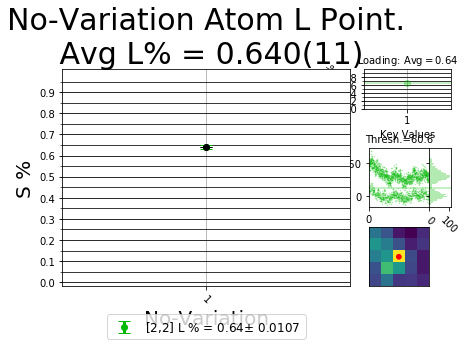

In [127]:
mp.Loading(red_optimum_file, [[2,2]], avgColor='k', mainAlpha=1,showImagePlots=False);

## OOO Optimized Loading

### raw data

Number of Pictures: 1000
Picture Dimensions: 5 x 5
Variaitons: 1
Repetitions: 1000
Experiment started at (H:M:S)  18:30:30:  on (Y-M-D) 2018-8-17
Analyzing Variation... 0, [0.0]


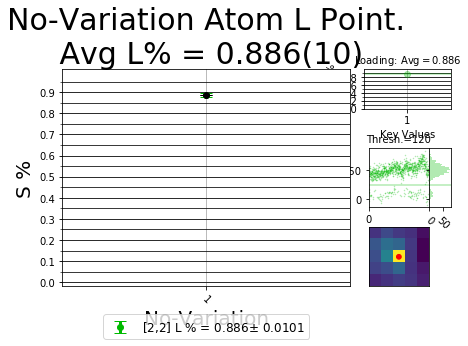

In [129]:
res = mp.Loading(single_optimum_file, [[2,2]], manualThreshold=120, avgColor='k', mainAlpha=1,showImagePlots=False);

In [135]:
with exp.ExpFile(single_optimum_file) as f:
    avgPic = f.get_avg_pic()

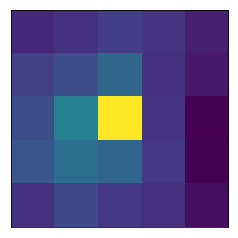

In [138]:
plt.imshow(avgPic)
plt.xticks([])
plt.yticks([]);
plt.savefig('Single_Atom_Image.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

### Optimized Loading Video

In [85]:
makeVid(res['Raw_Data'][50:150], 'Optimized_Single_Atom.gif', 'gif', dur=0.3,vidMap=viridisMap);

## OOO Grey Molasses Detuning & Trap Depth Vs Loading

### OOO Option 1

#### Raw Analysis

-7.55 
 [15.1, 17.100000000000001, 19.100000000000001, 21.199999999999999, 23.199999999999999, 25.300000000000001, 27.300000000000001, 29.399999999999999, 31.399999999999999, 33.399999999999999, 35.5, 37.5, 39.600000000000001, 41.600000000000001, 43.600000000000001, 45.700000000000003, 47.700000000000003, 49.799999999999997, 51.799999999999997, 53.899999999999999, 55.899999999999999, 57.899999999999999]


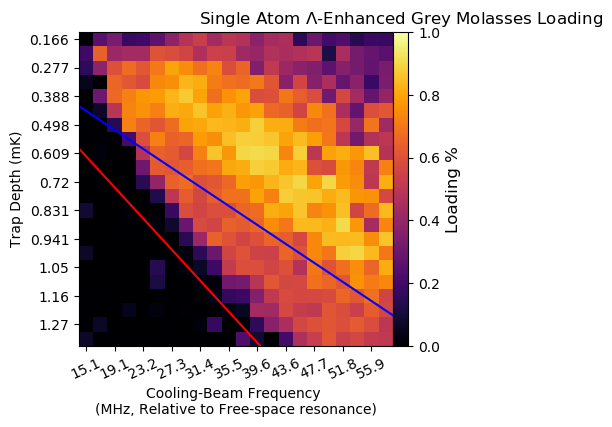

In [844]:
single_atom_analysis(grey_mol_file, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True, units='grey');

#### raw 3d bar plot

something's wrong...

In [840]:
from mpl_toolkits.mplot3d import Axes3D

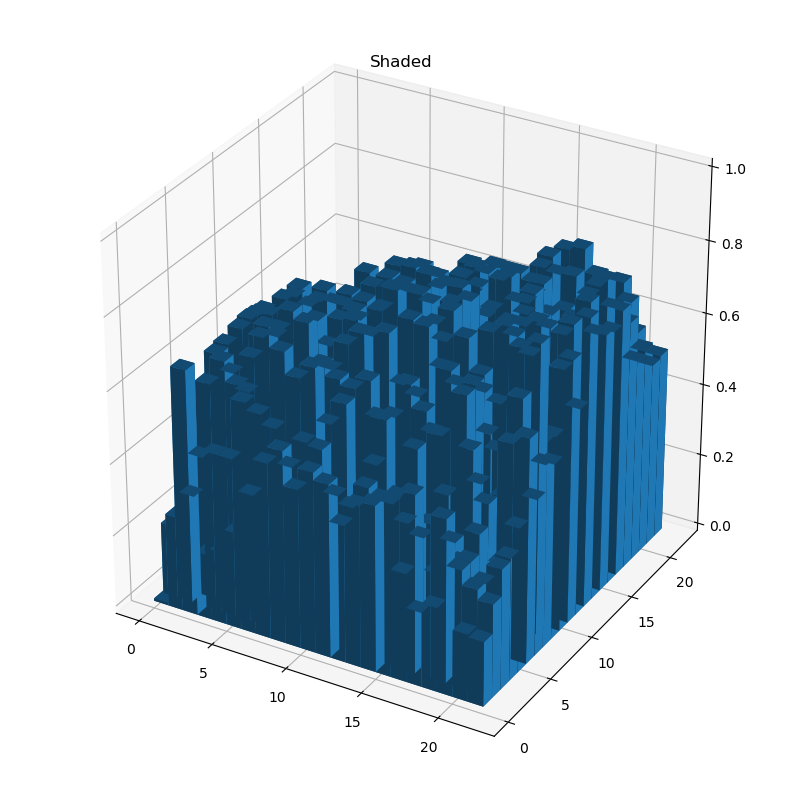

In [44]:
file = grey_mol_file
title = 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading'
realsize=False
if file is not None:
    res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
    ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
    avgLoading = avgLoading[0]
    avgLoadingErr = avgLoadingErr[0]
else:
    avgLoading = data
    avgLoadingErr = err
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
im_2dscan = np.zeros((len(key1),len(key2)))
f = plt.figure(figsize=(10,10))
if realsize:
    f.set_size_inches(4.25, 4.25)
for i, keyVal in enumerate(key):
    i1 = np.where(key1==keyVal[0])[0][0]
    i2 = np.where(key2==keyVal[1])[0][0]
    im_2dscan[i2,i1] = avgLoading[i]
    if showVals:
        plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
        plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')

ax1 = f.add_subplot(111, projection='3d')
# fake data
_xx, _yy = np.meshgrid(range(len(key2)), range(len(key1)))
x, y = _xx.ravel(), _yy.ravel()
bottom = np.zeros_like(x)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, im_2dscan.ravel(), shade=True )
ax1.set_title('Shaded')
ax1.set_zlim(0,1);
#im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
#plt.grid(False)
#plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
#plt.ylabel('Trap Depth (mK)')
#if controlUnits:
#    plt.xticks(range(0,len(key1),2),[misc.round_sig(k) for k in key1[::2]], rotation=50)
#    plt.yticks(range(0,len(key2),2),[misc.round_sig(k) for k in key2[::2]])
#else:
#    plt.xticks(range(0,len(key1),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=25);
#    plt.yticks(range(0,len(key2),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]]);
#divider = axesTool.make_axes_locatable(plt.gca())
#cax = divider.append_axes('right', size='5%', pad=0.0)    
#cb = f.colorbar(im, cax, orientation='vertical');
#cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
#if save:
#    plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
#plt.title(title)

#### OOO Optimizing Thresholds

In [851]:
yKey_g

[0.16600000000000001,
 0.222,
 0.27700000000000002,
 0.33200000000000002,
 0.38800000000000001,
 0.443,
 0.498,
 0.55400000000000005,
 0.60899999999999999,
 0.66500000000000004,
 0.71999999999999997,
 0.77500000000000002,
 0.83099999999999996,
 0.88600000000000001,
 0.94099999999999995,
 0.997,
 1.05,
 1.1100000000000001,
 1.1599999999999999,
 1.22,
 1.27,
 1.3300000000000001]

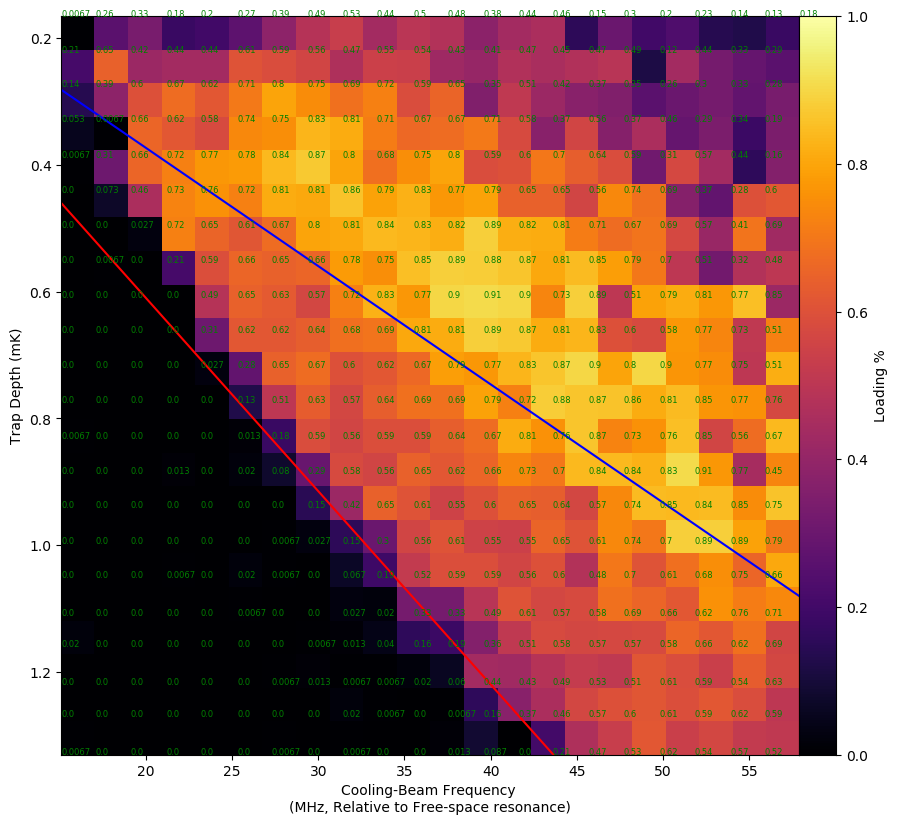

In [847]:
repsPerVar = 150
borders = [0,4,7,11,60,290,310,350,400,450,500]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(grey_mol_file) as f:
    kn, key_grey = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined_grey = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_grey += l
    errsCombined += e
single_atom_analysis_(None, 'Single_Atom_Grey_2D_Scan', realsize=False, data=avg_combined_grey, err=errsCombined, 
                      key=key_grey, units='grey', save=True, showVals=True)

### Option 2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning:

Covariance of the parameters could not be estimated



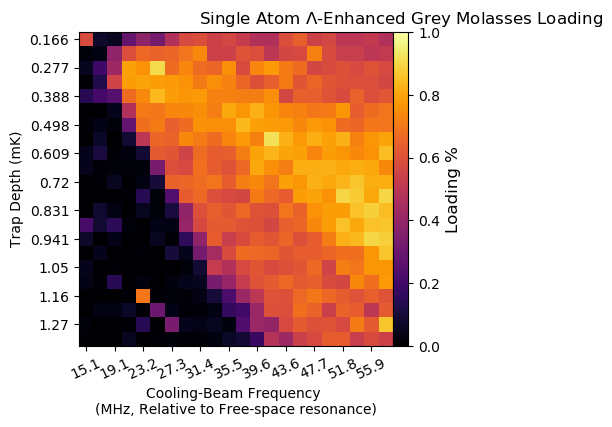

In [20]:
single_atom_analysis(alt_grey_mol_file, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True)

#### Optimizing Thresholds

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



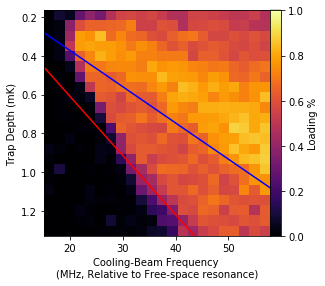

In [11]:
repsPerVar = 120
borders = [0,11,23,32,42,52,62,80,110,120,160,175,190,260,280,310,340,400,450,500]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(alt_grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(alt_grey_mol_file) as f:
    kn, key = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined += l
    errsCombined += e
single_atom_analysis_(None, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', 
                      realsize=True, data=avg_combined, err=errsCombined, key=key, units='grey')

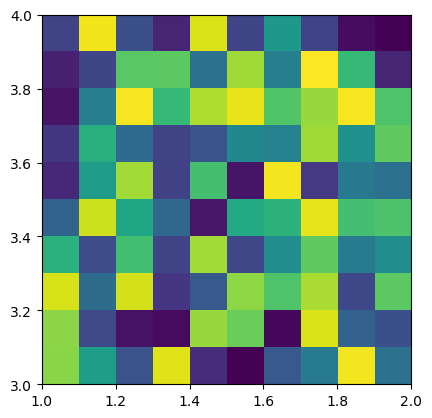

In [235]:
plt.imshow(np.random.random((10,10)), extent=[1,2,3,4])

## OOO Red PGC Detuning & Trap Depth Vs Loading

### Raw Data

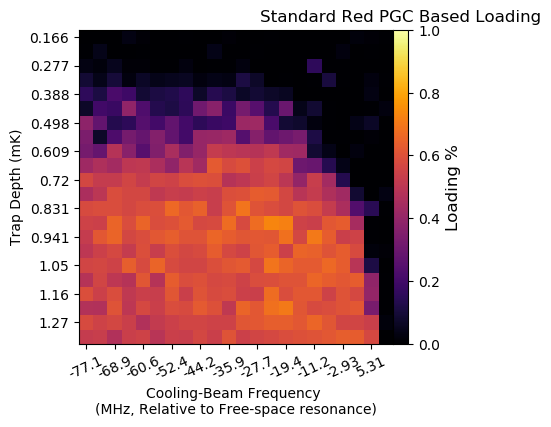

In [38]:
single_atom_analysis(red_pgc_file, 'Standard Red PGC Based Loading', realsize=True, units='red')

### OOO Optimizing Thresholds

In [852]:
reloadMyModules()

In [856]:
yKey_r

[0.16600000000000001,
 0.222,
 0.27700000000000002,
 0.33200000000000002,
 0.38800000000000001,
 0.443,
 0.498,
 0.55400000000000005,
 0.60899999999999999,
 0.66500000000000004,
 0.71999999999999997,
 0.77500000000000002,
 0.83099999999999996,
 0.88600000000000001,
 0.94099999999999995,
 0.997,
 1.05,
 1.1100000000000001,
 1.1599999999999999,
 1.22,
 1.27,
 1.3300000000000001]

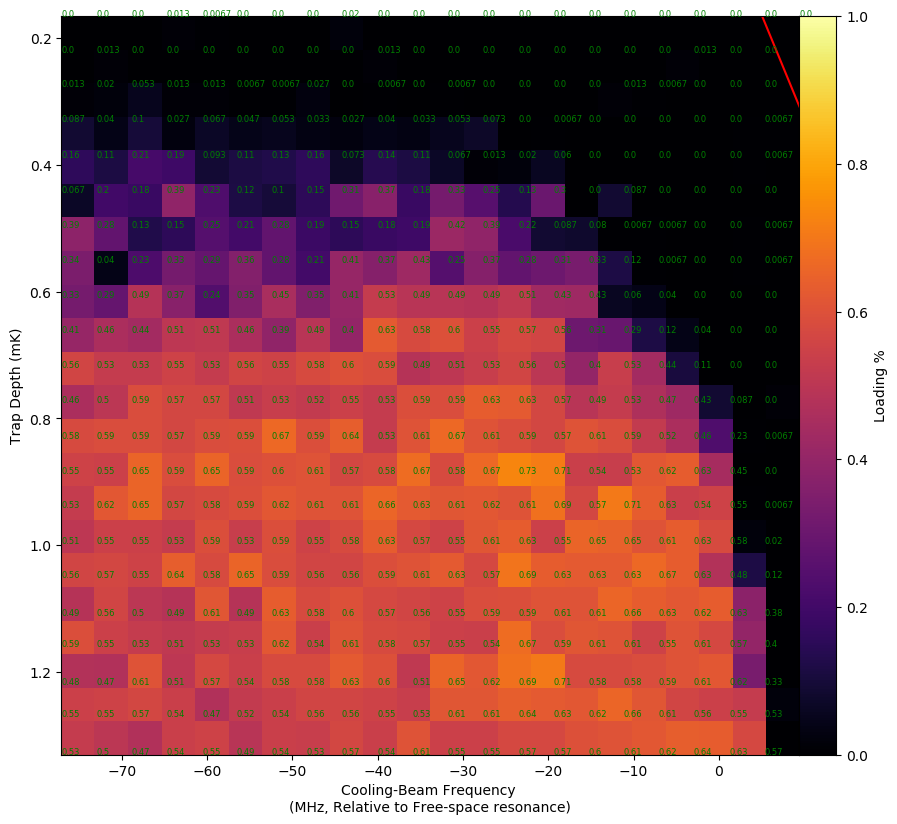

In [854]:
repsPerVar = 150
borders = [0,20,25,35,45, 50, 65, 90, 110, 200,250,300,350,400,650]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(red_pgc_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(red_pgc_file) as f:
    kn, key_red = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined_red = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_red += l
    errsCombined += e
single_atom_analysis_(None, 'Single_Atom_Red_2D_Scan', realsize=False, data=avg_combined_red, err=errsCombined, key=key_red, 
                      units='red', save=True, showVals=True)

# Combined Red & Blue Loading

Need to run the individual runs above first...

In [817]:
key1_r, key2_r = key_red[:,0], key_red[:,1]
key1_r = np.sort(np.unique(key1_r))
key2_r = np.sort(np.unique(key2_r))

key1_g, key2_g = key_grey[:,0], key_grey[:,1]
key1_g = np.sort(np.unique(key1_g))
key2_g = np.sort(np.unique(key2_g))

In [818]:
from matplotlib.colors import LinearSegmentedColormap
customCmap = []
inf = mpl.cm.get_cmap('inferno')
bcm = LinearSegmentedColormap.from_list( 'Custom_', [(0,0,1),(1,1,1)], N=255 )
s1 = 0.74
s2 = 1 - s1
for i in range(round(s1*255)):
    customCmap.append(inf(round(i/s1)))
for i in range(round(s2*255)):
    customCmap.append(bcm(round(i/s2)))
customCm = LinearSegmentedColormap.from_list( 'Custom', customCmap, N=255 )

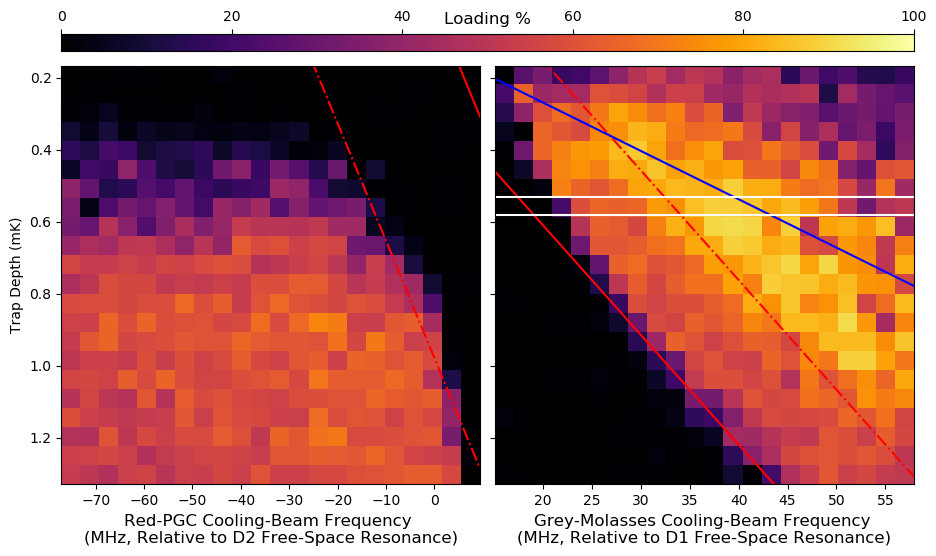

In [827]:
#cmap = customCm
cmap = 'inferno'
redImg = np.zeros((len(key1_r),len(key2_r)))
for i, keyVal in enumerate(key_red):
    i1 = np.where(key1_r==keyVal[0])[0][0]
    i2 = np.where(key2_r==keyVal[1])[0][0]
    redImg[i2,i1] = avg_combined_red[i]

greyImg = np.zeros((len(key1_g),len(key2_g)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_g==keyVal[0])[0][0]
    i2 = np.where(key2_g==keyVal[1])[0][0]
    greyImg[i2,i1] = avg_combined_grey[i]

xKey_r = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r]
yKey_r = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r]

xKey_g = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g]
yKey_g = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_g]

# mK per MHz
slope = 1 /( 20.8 + 9.86)
xpts = np.linspace(xKey_r[0], xKey_r[-1], 1000)

    
f = plt.figure(figsize=(20,10))
f.set_size_inches(11,11)
# as in plt.subplot(111)
ax = axesTool.ImageGrid(f, 111,
                     nrows_ncols=(1,2),
                     axes_pad=0.15,
                     #share_all=True,
                     label_mode="L",
                     cbar_location="top",
                     cbar_mode="single",
                     cbar_size="150%",
                     cbar_pad=0.15)
plt.sca(ax[0])
#plt.title('Standard Loading', y=1.1)
#plt.yticks(range(0,len(key2_r),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r[::2]]);
#plt.xticks(range(0,len(key1_r),2),[misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r[::2]], rotation=45);
plt.xlabel('Red-PGC Cooling-Beam Frequency \n(MHz, Relative to D2 Free-Space Resonance)',fontsize=12)

plt.sca(ax[1])
#plt.title('$\Lambda$-Enhanced Loading')
#plt.xticks(range(0,len(key1_g),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g[::2]], rotation=45);
plt.xlabel('Grey-Molasses Cooling-Beam Frequency \n(MHz, Relative to D1 Free-Space Resonance)',fontsize=12)

ax[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
ax[0].plot(xpts, linear.f(xpts, slope, slope * 30), color='r', linestyle='-.', zorder=2 )
ax[0].set_ylabel('Trap Depth (mK)')
# 
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(3 * 20.8 + 12.0)
xpts = np.linspace(xKey_g[0], xKey_g[-1], 1000)
ax[1].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slope, -slope*15), color='r', linestyle='-.', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', linestyle='-',zorder=2 )
ax[1].axhline((yKey_g[6] + yKey_g[7]+0.01)/2,color='w')
ax[1].axhline((yKey_g[7] + yKey_g[8])/2,color='w')
ax[0].imshow( redImg*100, cmap=cmap, vmin=0, vmax=100, zorder=1,
              extent = [xKey_r[0],xKey_r[-1], yKey_r[-1],yKey_r[0]], 
              aspect=(xKey_r[-1]-xKey_r[0])/(yKey_r[-1]-yKey_r[0]) )
im = ax[1].imshow( greyImg * 100, cmap=cmap, vmin=0, vmax=100, zorder=1,
                   extent = [xKey_g[0],xKey_g[-1], yKey_g[-1],yKey_g[0]], 
                   aspect=(xKey_g[-1]-xKey_g[0])/(yKey_g[-1]-yKey_g[0]))
cb = ax.cbar_axes[0].colorbar(im);
cb.set_label_text( "Loading %", size=12 )
cb.ax.xaxis.labelpad=-10
plt.savefig( 'Single_Atom_Loading_Red_And_Grey.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

# 100 Atoms

## Best Run

This run is from September 6th, some time after the initial runs. Its a long run so I think it's reasonably real, and it's the best long run I have

Number of Pictures: 10000
Picture Dimensions: 25 x 23
Variaitons: 1
Repetitions: 5000
Experiment started at (H:M:S)  20:27:46:  on (Y-M-D) 2018-9-6


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



Analyzing Variation... 0, [0.0035917401409344745]


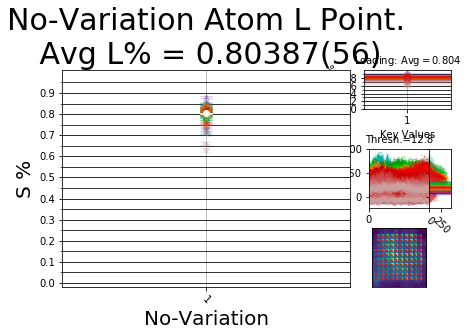

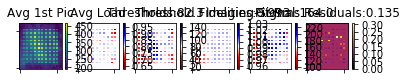

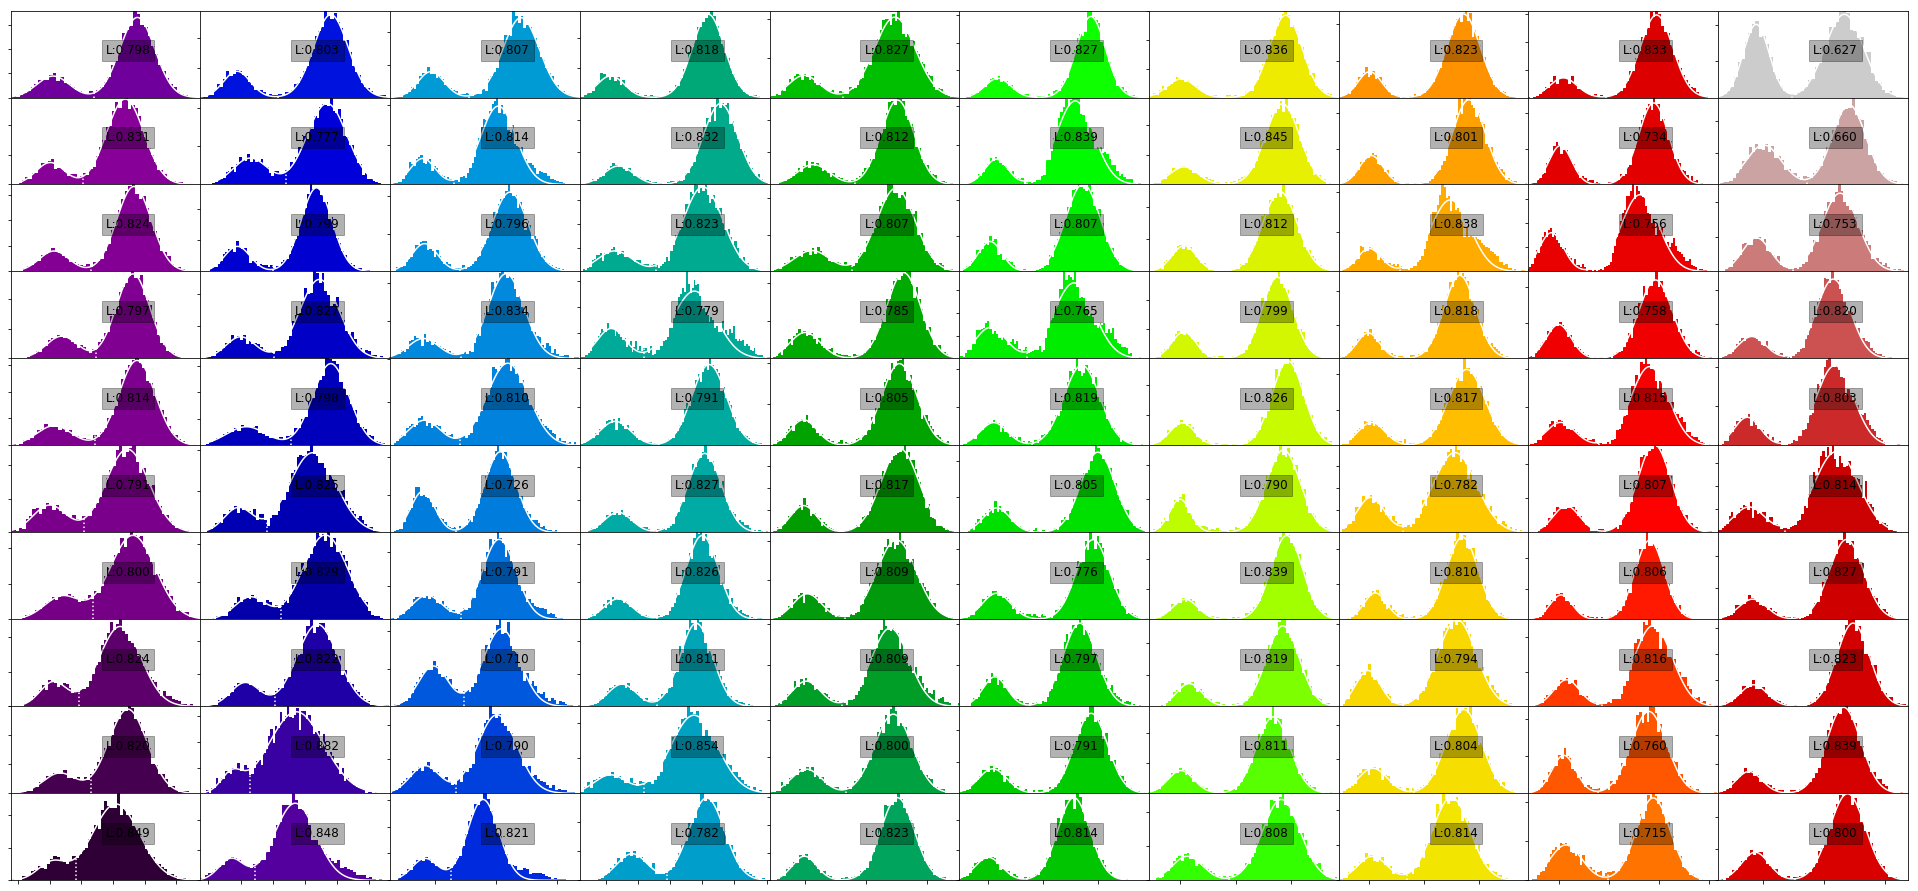

In [139]:
res = mp.Population('Sep_6_Grey_10x10_Loading_80_p_4.h5',[3,2,2,10,10],0,2, plotIndvHists=True);

In [140]:
pics = res["Raw_Data"][::2]

The pictures weren't square, there was an extra border pixel in the vertical direction, so square it up.

In [141]:
pics_ = pics[:,1:24,:]

In [142]:
avgPic = np.zeros(pics_[0].shape)
for p in pics_:
    avgPic += p

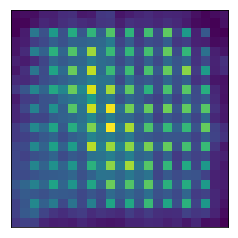

In [146]:
plt.imshow(avgPic,origin='bottom')
plt.xticks([])
plt.yticks([]);
plt.savefig('10x10_Atom_Image.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

In [334]:
makeVid(pics_[50:150], '10x10_best.gif', 'gif', dur=0.15, vidMap=viridisMap, offset=100, maxMult=2, includeCount=False);

In [125]:
def makeVid( pics, gifAddress, videoType, fileAddress=None, dur=1, lim=None, includeCount=True, lowLim=None, 
             finLabels=[], finTxt="Atom Reservoir Depleted", vidMap=infernoMap ):
    # global count
    # select subsection
    if lim is None:
        lim = len(pics)
    if lowLim is None:
        lowLim = 0
    pics = pics[lowLim:lim]
    # normalize to rgb scale
    pics = pics - min(pics.flatten())
    pics = np.uint16(pics / max(pics.flatten()) * 500)
    pics = arr([[[int(elem) for elem in row] for row in pic] for pic in pics])
    pics = arr(pics-min(pics.flatten()) - 125)
    pics = [[[vidMap[elem] if elem < 256 and elem >= 0 else vidMap[255] if elem >= 256 else vidMap[0] 
              for elem in row] for row in pic] for pic in pics]
    images = []
    sequenceCount = 1
    offset = 0
    for picCount, pic in enumerate(pics):
        fig = plt.figure()
        fig.set_size_inches([9,9])
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.grid(False)
        ax.imshow(pic, aspect='equal')
        #ax.text(1, 1, str(picCount+1-offset), color='white', fontsize=40)
        if picCount+1 in finLabels:
            ax.text(1.5, 14, finTxt, color='r', fontsize=40)
        name = "temp"+str(picCount+1)+".png"
        plt.savefig(name)
        images.append(imageio.imread(name))
        if picCount+1 in finLabels:
            sequenceCount += 1
            offset = picCount+1
            for _ in range(4):
                images.append(imageio.imread(name))
        plt.close('all')
    # make bigger
    pics = [np.repeat(np.repeat(pic,32, axis=0), 32, axis=1) for pic in pics]
    imageio.mimsave(gifAddress, images, format=videoType, duration=dur)

In [89]:
for k in res:
    print(k)

Key
Loading
Loading_Error
Pixel_Counts
Atom_Images
Thresholds
Atom_Data
Raw_Data


## single shot images

In [155]:
file = grey_mol_file_10x10
res = ma.standardPopulationAnalysis( file, [3,2,2,10,10], 0, 1, quiet=True, subtractEdges=False);
( fullPixelCounts, thresholds, avgPic, key, avgLoadingErr, avgLoading, allLoadingRate, allLoadingErr, loadFits,
  fitModule, keyName, totalAtomData, rawData, atomLocations, avgFits, atomImages, totalAvg, totalErr ) = res

In [156]:
thresholds[0].t

231.65947117283207

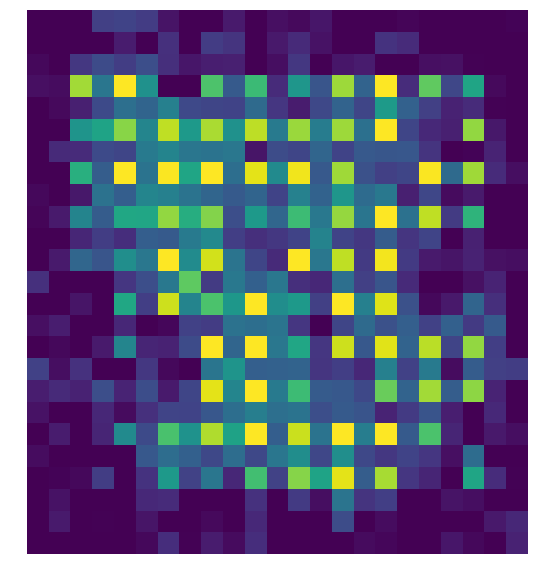

In [201]:
plt.figure(figsize=(10,10))
plt.imshow(rawData[5702], vmin=200, vmax=450, origin='bottom', cmap='viridis')
plt.axis('off');
plt.savefig('80_Atoms.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

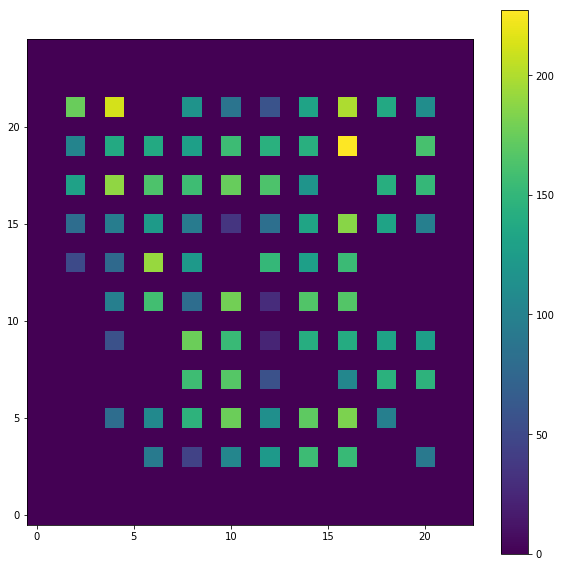

In [200]:
minv = 0
data = np.zeros((25,23)) + minv
plt.figure(figsize=(10,10))
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    #print(thresholds[i].t)
    data[loc[0],loc[1]] = rawData[5702][loc[0],loc[1]]-thresholds[i].t - minv
plt.imshow(data, origin='bottom',vmin=minv)
plt.colorbar()


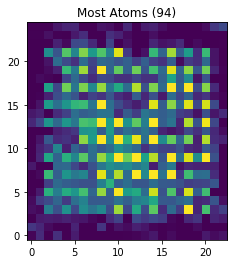

In [116]:
plt.title('Most Atoms (94)')
plt.imshow(rawData[np.argmax(atomNums)], origin='bottom', vmin=200, vmax=450)

In [117]:
atomNum80s = [i for i, x in enumerate(atomNums) if x == 80]

for index in atomNum80s[:100]:
    f, ax = plt.subplots(1,2)
    ax[0].imshow(rawData[index], vmin=200, vmax=400)
    ax[1].imshow(atomImages[index])
    plt.title(index)

## Detuning & Trap Depth Vs. Loading

### Raw Analysis

#### Main Data

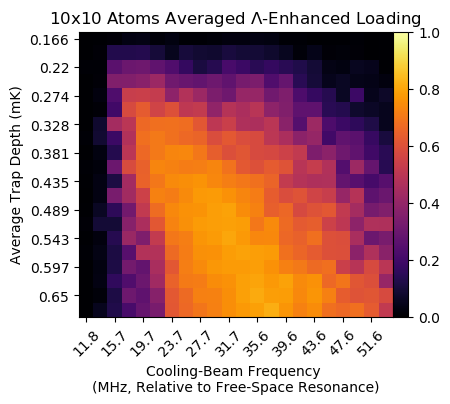

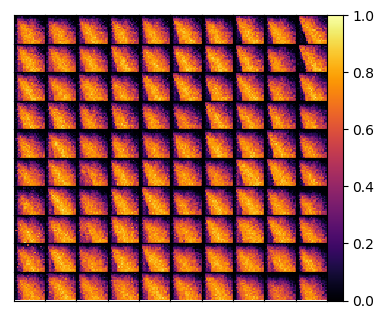

In [23]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False, 
save=False
key=None
data=None
err=None
res = ma.standardPopulationAnalysis( file, [3,2,2,10,10], 0, 1, quiet=True);
( _,_,_, key, avgLoadingErr, avgLoading, _, _, _,  _, _, _, _, _, _, _, _, _, ) = res
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2 = [k for k in key2 if k <= 205]
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(avgLoading)]
im_2dscan = np.zeros((len(key2),len(key1)))
f = plt.figure(figsize=(10,10))
if realsize:
    f.set_size_inches(4.25, 4.25)
for i, keyVal in enumerate(key):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    im_2dscan[i2,i1] = avgAvgLoading[i]
    if showVals:
        text(i1-0.5, i2+0.25, misc.round_sig(avgAvgLoading[i], 2), fontsize=8, color='g')

im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
plt.grid(False)
plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-Space Resonance)')
plt.ylabel('Average Trap Depth (mK)')
if controlUnits:
    xticks(range(0, len(key1), 2),[misc.round_sig(k) for k in key1[::2]], rotation=50)
    yticks(range(0, len(key2), 2),[misc.round_sig(k) for k in key2[::2]])
else:
    plt.xticks(range(0, len(key1), 2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=45);
    plt.yticks(range(0, len(key2), 2),[misc.round_sig(TweezerPowerToDepth.f(k/100)) for k in key2[::2]]);

plt.title(title)
divider = axesTool.make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.0)
f.colorbar(im, cax, orientation='vertical');
if save:
    plt.savefig('Raw_10x10.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
# indv atom fig
fig = plt.figure(figsize=(20,20))
if realsize:
    fig.set_size_inches(4.25, 4.25)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(10, 10), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
for atomInc in range(100):
    num = 100 - 10*((atomInc % 10)+1) + atomInc // 10
    ax = grid[num]
    im_2dscan = np.zeros((len(key2),len(key1)))
    for i, keyVal in enumerate(key):
        try:            
            i1 = np.where(key1==keyVal[0])[0][0]
            i2 = np.where(key2==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        im_2dscan[i2,i1] = avgLoading[atomInc][i]
    ax.grid(False)
    plt.sca(ax)
    plt.xticks([],[])
    plt.yticks([],[])
    ax.axis('on')
    im = ax.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
    ax.grid(False)
grid.cbar_axes[0].colorbar(im);
if save:
    pass

#### Max Loading for each atom

Mean Maximum Loading Value: 0.8898


Text(0.5,1,'Max loading for each atom')

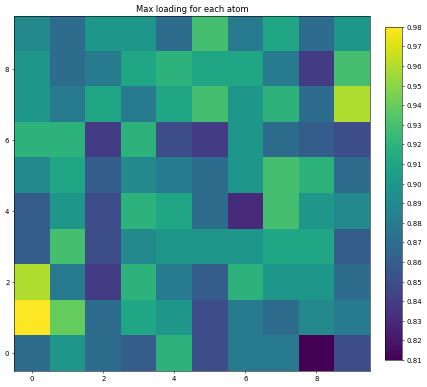

In [25]:
maxData = []
for atomLoc in range(100):
    maxData.append(max(avgLoading[atomLoc]))
maxData = [maxData[i] if maxData[i] is not None else np.mean([i for i in maxData if i is not None]) for i in range(len(maxData))] 
print('Mean Maximum Loading Value:', np.mean(maxData))
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
plt.figure(figsize=(10,10), dpi=50)
im = plt.imshow(misc.transpose(np.reshape(maxData,(10,10))), origin='bottom')
cb = plt.colorbar(im, ax=plt.gca(),fraction=0.043, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=20)
cb.locator = tick_locator
cb.update_ticks()
plt.title('Max loading for each atom')

### Optimizing Thresholds

#### Main Data

In [340]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False, 
save=True
key=None
data=None
err=None
repsPerVar = 100
borders = [int(x) for x in np.linspace(0,484,20)]
errs, pixels, thresh, data = [[[None for _ in range(len(borders)-1)] for _ in range(100)] for _ in range(4)]
print('Collecting Data sorting through borders...',end='')
for bi in range(len(borders)-1):
    print('.',end='')
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(file, [3,2,2,10,10], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    for ai in range(100):
        errs[ai][bi], thresh[ai][bi], pixels[ai][bi], data[ai][bi] = res[4][ai], res[1][ai], res[0][ai], res[5][ai]
print('.')
with exp.ExpFile(file) as f:
    kn, key_10 = f.get_key()
key1_10, key2_10 = key_10[:,0], key_10[:,1]
key1_10 = np.sort(np.unique(key1_10))
key2_10 = np.sort(np.unique(key2_10))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2_10 = [k for k in key2_10 if k <= 190]
# unitful
xKey_10 = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_10]
yKey_10 = [misc.round_sig(TweezerPowerToDepth.f(k)/100) for k in key2_10]

optData = [[] for _ in range(100)]
for atomInc in range(100):
    for borderInc in range(len(data[atomInc])):
        optData[atomInc] += data[atomInc][borderInc]
# (To see (kinda) where the threshold regions are)
#figure(figsize=(20,5))
#for ai in range(100):
#    x_i = 0
#    for p, t in zip(pixels[ai], thresh[ai]):
#        plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#        hlines(t, xmin=x_i, xmax=x_i + len(p), color='k')
#        x_i += len(p)
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(optData)]
im_2dscan = np.zeros((len(key2_10),len(key1_10)))
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1_10==keyVal[0])[0][0]
        i2 = np.where(key2_10==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    im_2dscan[i2,i1] = avgAvgLoading[i]
    if showVals:
        plt.text(i1-0.5, i2+0.25, misc.round_sig(avgAvgLoading[i], 2), fontsize=8, color='g')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



................


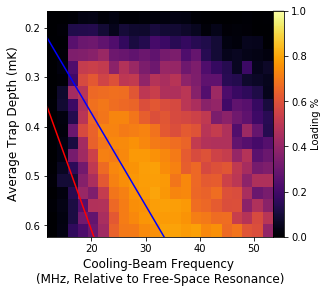

In [341]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
grid[0].imshow( im_2dscan, cmap='inferno', vmin=0, vmax=1,
                extent = [xKey_10[0],xKey_10[-1], yKey_10[-1],yKey_10[0]],
                aspect=(xKey_10[-1]-xKey_10[0])/(yKey_10[-1]-yKey_10[0]))

# this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
xpts = np.linspace(xKey_10[0], xKey_10[-1], 1000)
grid[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
grid[0].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )

plt.grid(False)
grid[0].set_xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-Space Resonance)',fontsize=paper_Font_Size)
grid[0].set_ylabel('Average Trap Depth (mK)',fontsize=paper_Font_Size)
grid[0].set_xlim(xKey_10[0], xKey_10[-1])
grid[0].set_ylim(yKey_10[-1],yKey_10[0]);
cb = grid.cbar_axes[0].colorbar(im);
axis = grid.cbar_axes[0].axis['right']
axis.label.set_text("Loading %")

plt.savefig('10x10_Lambda_Loading_2D_Scan.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


#### Version for combining with grey loading

It's not trivial to get the aspects exactly correct using subplots, (seems like the best option would be to use gridspec, but I'm liking AxesTool), so instead just make two plots that can be combined separately.

In [342]:
with exp.ExpFile(grey_mol_file) as f:
    kn, key_1 = f.get_key()
key1_1, key2_1 = key_1[:,0], key_1[:,1]
key1_1 = np.sort(np.unique(key1_1))
key2_1 = np.sort(np.unique(key2_1))
yKey_1 = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_1]
squishRatio = ((yKey_1[-1] - yKey_1[0])/(yKey_10[-1]-yKey_10[0]))**-1

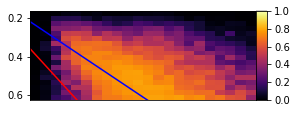

In [343]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
grid[0].imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1,
                extent = [xKey_10[0],xKey_10[-1], yKey_10[-1],yKey_10[0]],
               aspect=(xKey_10[-1]-xKey_10[0])/(yKey_10[-1]-yKey_10[0]) * squishRatio)

# this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
xpts = np.linspace(xKey_10[0], xKey_10[-1], 1000)
grid[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
grid[0].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )

plt.grid(False)
#grid[0].set_xlabel('Cooling-Beam Frequency \n(MHz, Rel. to Free-Space Resonance)',fontsize=paper_Font_Size)
#grid[0].set_ylabel('Avg Depth (mK)',fontsize=paper_Font_Size)
grid[0].set_xlim(xKey_10[0], xKey_10[-1])
grid[0].set_ylim(yKey_10[-1],yKey_10[0]);
cb = grid.cbar_axes[0].colorbar(im);
grid[0].set_xticks([])
plt.savefig('10x10_Lambda_Loading_2D_Scan_squish.png', transparent=True, bbox_inches='tight', pad_inches=0.1,dpi=400)


#### indv atoms

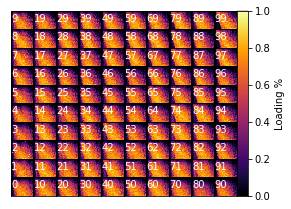

In [344]:
# ### Indv Atoms
fig = plt.figure(figsize=(10,10))
fig.set_size_inches(4.25, 4.25)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(10, 10), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
for atomInc in range(100):
    num = 100 - 10*((atomInc % 10)+1) + atomInc // 10
    ax = grid[num]
    im_2dscan = np.zeros((len(key2_10),len(key1_10)))
    for i, keyVal in enumerate(key_10):
        try:
            i1 = np.where(key1_10==keyVal[0])[0][0]
            i2 = np.where(key2_10==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        im_2dscan[i2,i1] = optData[atomInc][i]
    ax.grid(False)
    plt.sca(ax)
    plt.xticks([],[])
    plt.yticks([],[])
    ax.axis('on')
    im = ax.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
    ax.grid(False)
    ax.text(0,10,atomInc,color='w')
cb = grid.cbar_axes[0].colorbar(im);
axis = grid.cbar_axes[0].axis['right']
axis.label.set_text("Loading %")
if save:
    plt.savefig('10x10_Individual_Atoms_Grey_Molasses.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400);

In [345]:
# used for single atom grey and red loading scans
def single_atom_analysis_(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    if realsize:
        f.set_size_inches(4.25, 4.25)
    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
    if units is None:
        xKey = [misc.round_sig(k) for k in key1]
        yKey = [misc.round_sig(k) for k in key2]
    elif units == "red":
        xKey = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
    elif units == "grey":
        xKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]

    im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1,
                    extent = [xKey[0],xKey[-1], yKey[-1],yKey[0]], aspect=(xKey[-1]-xKey[0])/(yKey[-1]-yKey[0]))
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1 /( 20.8 + 9.86)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        plt.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1/(20.8 + 12.0)
        slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        plt.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
        plt.plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )
    
    #plt.xticks(range(0,len(key1),2), xKey, rotation=25);
    #plt.yticks(range(0,len(key2),2), yKey);

    plt.grid(False)
    plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
    plt.ylabel('Trap Depth (mK)')
    plt.xlim(xKey[0], xKey[-1])
    plt.ylim(yKey[-1],yKey[0]);
    """
    divider = axesTool.make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.0)
    cb = f.colorbar(im, cax, orientation='vertical');
    cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
    plt.title(title)
    """
    if save:
        plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


### Histogram

In [ ]:
arr(optData)[0]

In [362]:
histData = [[[None] for _ in range(22)] for _ in range(20)]
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    histData[i2][i1] = arr(optData)[:,i]*100

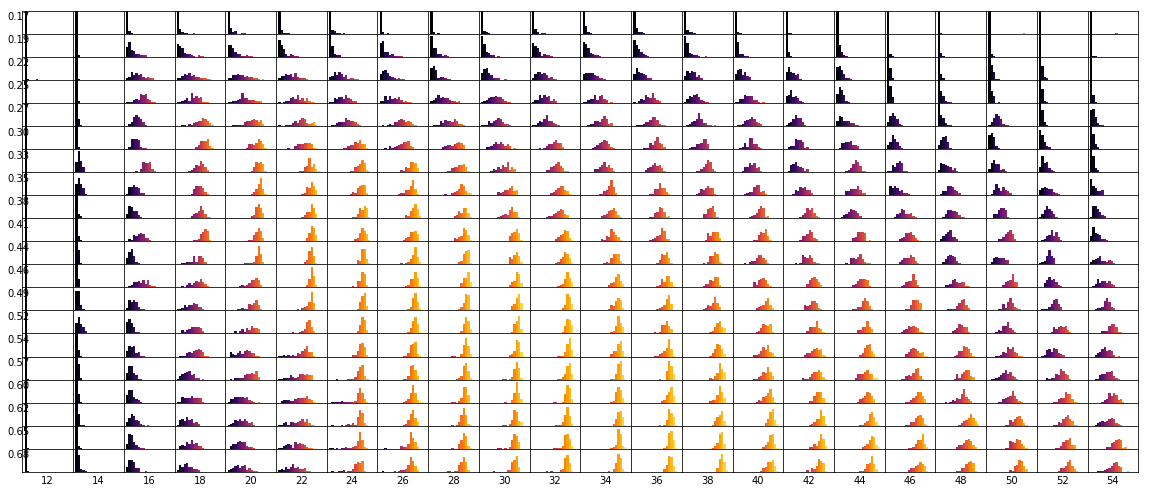

In [364]:
fig = plt.figure(figsize=(20,20))
inf = plt.get_cmap('inferno', 20)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(20, 22), axes_pad=0.0, share_all=True)
                          #label_mode="L", cbar_location="right", cbar_mode="single" )
gridgrid = np.reshape(grid, (20,22))
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    a = gridgrid[i2][i1]
    # histData = arr(optData)[:,i]*100
    N3, bins, patches = a.hist(histData[i2][i1], bins=np.arange(0,105,5))
    a.set_ylim(0,50)
    plt.sca(a)
    plt.xticks([],[])
    plt.yticks([],[])
    a.set_xlabel(misc.round_sig_str(D1_DacToFreq.f(keyVal[0]),2))
    a.set_ylabel(misc.round_sig_str(TweezerPowerToDepth.f(keyVal[1])/100,2), rotation=0)
    for k in range(len(patches)):
        patches[k].set_facecolor(inf(k))

In [394]:
arr(histData).shape

(20, 22, 100)

In [396]:
yKey_10[14]

0.54300000000000004

In [467]:
inf = plt.get_cmap('inferno', 20)

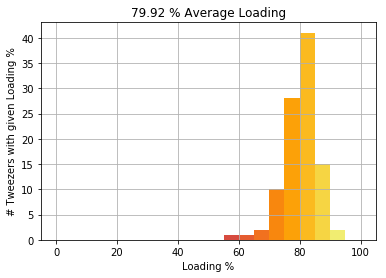

In [469]:
which = 10
wr = 14
N3, bins, patches = plt.hist(histData[wr][which], bins=np.arange(0,105,5))
plt.title(str(np.mean(histData[wr][which])) + ' % Average Loading')
plt.xlabel('Loading %')
plt.grid(True)
plt.ylabel('# Tweezers with given Loading %')
for k in range(len(patches)):
    patches[k].set_facecolor(inf(k))
#plt.savefig('Single_Hist_Example.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

#### Max Loading for each atom

In [ ]:
maxData = []
for atomLoc in range(100):
    maxData.append(max(avgLoading[atomLoc]))
maxData = [maxData[i] if maxData[i] is not None else np.mean([i for i in maxData if i is not None]) for i in range(len(maxData))] 
print("Mean Atom's Maximum Loading:", np.mean(maxData))
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
plt.figure(figsize=(10,10), dpi=50)
im = plt.imshow(misc.transpose(np.reshape(maxData,(10,10))), origin='bottom')
cb = plt.colorbar(im, ax=plt.gca(),fraction=0.043, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=20)
cb.locator = tick_locator
cb.update_ticks()
plt.title('Max loading for each atom');

# Tweezer Videos

In [336]:
reloadMyModules()

In [337]:
pics_static = ah.loadCompoundBasler('AceData_Static_10x10.txt')
pics_ramp = ah.loadCompoundBasler('AceData_RampDown.txt')
pics_move = ah.loadCompoundBasler('AceData_Move.txt')

KeyboardInterrupt: 

In [ ]:
pics_static_avg = [np.zeros(pics_static[0].shape) for _ in range(3)]
for i, pic in enumerate(pics_static):
    pics_static_avg[i//10] += pic

In [ ]:
pics_ramp_avg = [np.zeros(pics_ramp[0].shape) for _ in range(101)]
for i, pic in enumerate(pics_ramp):
    pics_ramp_avg[i//10] += pic

In [ ]:
pics_move_avg = [np.zeros(pics_move[0].shape) for _ in range(101)]
for i, pic in enumerate(pics_move):
    pics_move_avg[i//10] += pic

In [ ]:
allPics = pics_ramp_avg + pics_move_avg

In [ ]:
makeVid(arr(allPics), "TweezerMove.gif", "gif", dur=0.02, includeCount=False, vidMap=magmaMap,resolutionMult=1)

In [345]:
arr(viridisMap[0]) * 255

array([ 68.08602 ,   1.24287 ,  84.000825])

In [349]:
arr(cividisMap[0]) * 255

array([  0.      ,  34.45356 ,  77.711505])

In [350]:
arr(infernoMap[0]) * 255

array([ 0.37281,  0.11883,  3.53583])

In [351]:
arr(magmaMap[0]) * 255

array([ 0.37281,  0.11883,  3.53583])